In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Data/complaints.csv.zip')
df.iloc[:,:10].head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206
2,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX
3,2019-09-15,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,Pioneer has committed several federal violatio...,NaN,Pioneer Capital Solutions Inc,CA,925XX
4,2021-03-02,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",FL,33325


In [6]:
df = df[pd.notnull(df['Consumer complaint narrative'])]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679285 entries, 0 to 1999963
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 679285 non-null  object
 1   Product                       679285 non-null  object
 2   Sub-product                   627113 non-null  object
 3   Issue                         679285 non-null  object
 4   Sub-issue                     528206 non-null  object
 5   Consumer complaint narrative  679285 non-null  object
 6   Company public response       339012 non-null  object
 7   Company                       679285 non-null  object
 8   State                         675680 non-null  object
 9   ZIP code                      528244 non-null  object
 10  Tags                          111909 non-null  object
 11  Consumer consent provided?    679285 non-null  object
 12  Submitted via                 679285 non-null  object
 13

In [8]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]

In [9]:
df.columns

Index(['Product', 'Consumer complaint narrative'], dtype='object')

In [10]:
df.columns = ['Product', 'Consumer_complaint_narrative']

In [11]:
df['category_id'] = df['Product'].factorize()[0]

In [12]:
from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')

# Mapping Dictionaries
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [13]:
df.head()

,Product,Consumer_complaint_narrative,category_id
0,Debt collection,transworld systems inc. \nis trying to collect...,0
2,Debt collection,"Over the past 2 weeks, I have been receiving e...",0
3,Debt collection,Pioneer has committed several federal violatio...,0
8,"Credit reporting, credit repair services, or o...","Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/...",1
9,"Credit reporting, credit repair services, or o...",Hello This complaint is against the three cred...,1


In [14]:
import sys
sys.getsizeof(df)/(1024**3)

0.7826486974954605

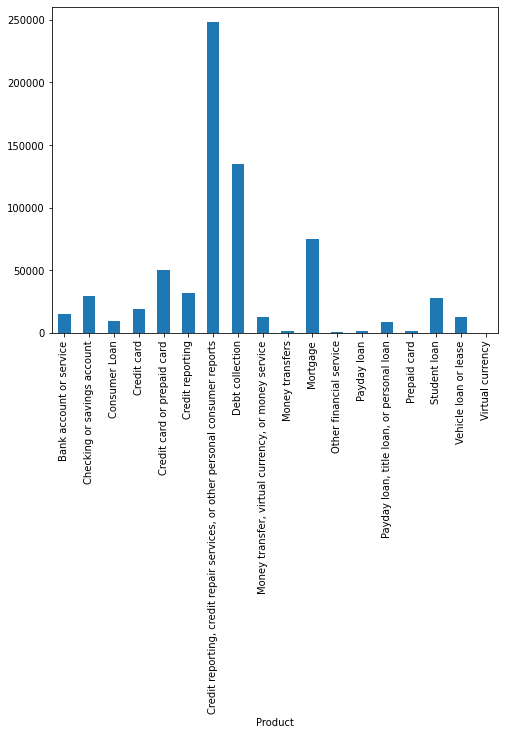

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

# Undersample the High Frequency Classes - Using Median Count

In [16]:
df['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    248115
Debt collection                                                                 134651
Mortgage                                                                         75042
Credit card or prepaid card                                                      50365
Credit reporting                                                                 31588
Checking or savings account                                                      29404
Student loan                                                                     27735
Credit card                                                                      18838
Bank account or service                                                          14885
Money transfer, virtual currency, or money service                               12994
Vehicle loan or lease                                                            12287
Consumer Loan                              

In [17]:
print('Minority Class Count : ', df['Product'].value_counts().min())
print('Majority Class Count : ', df['Product'].value_counts().max())

Minority Class Count :  16
Majority Class Count :  248115


In [18]:
# Percentage of majority relative to the minority class
samplingStrategy = 0.01

In [19]:
import numpy as np

# Undersampling using sampling strategy 
nsamples_per_class = np.int16(df['Product'].value_counts().min()/samplingStrategy)
undersample = lambda df: df.loc[np.random.choice(a=df.index, size=min(len(df.index), nsamples_per_class), replace=False)]
df_bal = df.groupby(['Product'], as_index=False).apply(undersample)

print(df_bal.shape)

(25655, 3)


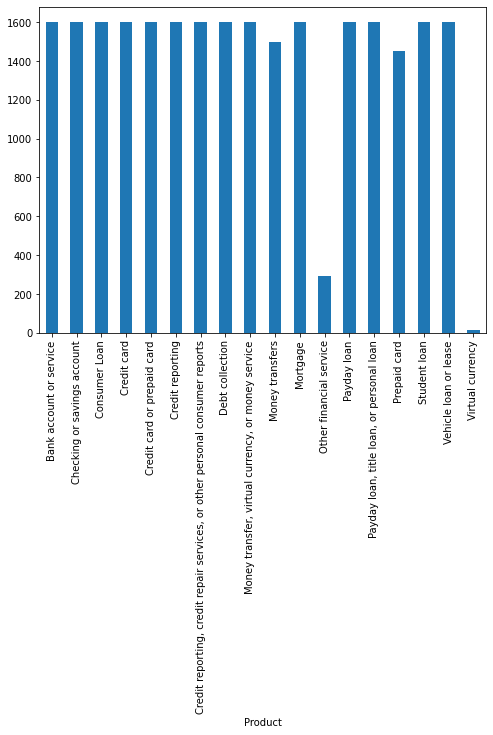

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_bal.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [21]:
df = df_bal

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Consumer_complaint_narrative)
labels = df.category_id
features.shape

(25655, 71253)

In [23]:
import sys
sys.getsizeof(features)/(1024**3)

5.960464477539063e-08

In [24]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
df_feat = pd.DataFrame(columns=['Product', 'Unigrams', 'Bigrams'])

for product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])

  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

  # Top N most correlated unigrams and bigrams for each category
  df_cat = pd.DataFrame(index=range(N), columns=['Product', 'Unigrams', 'Bigrams'])
  df_cat['Product'] = product
  df_cat['Unigrams'] = unigrams[-N:]
  df_cat['Bigrams'] = bigrams[-N:]
  
  df_feat = pd.concat([df_feat, df_cat], axis=0, ignore_index=True)

In [25]:
df_feat.head(20)

,Product,Unigrams,Bigrams
0,Bank account or service,citigold,checking account
1,Bank account or service,overdraft,overdraft fees
2,Checking or savings account,checking,savings account
3,Checking or savings account,branch,checking account
4,Consumer Loan,car,car loan
5,Consumer Loan,vehicle,auto loan
6,Credit card,macy,synchrony bank
7,Credit card,card,credit card
8,Credit card or prepaid card,capital,credit limit
9,Credit card or prepaid card,card,credit card


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [27]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


In [28]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Credit reporting']


In [29]:
df[df['Consumer_complaint_narrative'] == "This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]

,,Product,Consumer_complaint_narrative,category_id


In [30]:
df[df['Consumer_complaint_narrative'] == "I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"]

,,Product,Consumer_complaint_narrative,category_id


# Baseline Classifiers

- Logistic Regression
- (Multinomial) Naive Bayes
- Linear Support Vector Machine
- Random Forest

# Optimize Baseline Models Using GridSearchCV

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

## Multinomial Naive Bayes Classifier

In [ ]:
# Implement the grid search
pipe = Pipeline([("vectorizer", CountVectorizer()), 
                 ("classifier", MultinomialNB())])

params = {'vectorizer__ngram_range':[(1,1), (1,2)], 
          'classifier__alpha':[1, 0.1]}

gridCV = GridSearchCV(pipe, param_grid=params)

# Train the Multinomial Naive Bayes classifier  
gridCV.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                   

In [ ]:
print(gridCV.best_params_)
print(gridCV.best_score_)

{'classifier__alpha': 0.1, 'vectorizer__ngram_range': (1, 2)}
0.6179514456599413


In [ ]:
# Evaluate the Multinomial Naive Bayes classifier
y_pred = gridCV.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.56      0.51      0.53       402
                                                 Checking or savings account       0.57      0.64      0.60       405
                                                               Consumer Loan       0.53      0.36      0.43       370
                                                                 Credit card       0.54      0.50      0.52       412
                                                 Credit card or prepaid card       0.53      0.54      0.53       401
                                                            Credit reporting       0.61      0.68      0.64       409
Credit reporting, credit repair services, or other personal consumer reports       0.56      0.56      0.56       386
                                                       

## Logistic Regression Classifier

In [ ]:
# Implement the grid search
pipe = Pipeline([('vectorizer', CountVectorizer()), 
                 ('classifier', LogisticRegression())])

params = {'vectorizer__ngram_range':[(1,1), (1,2)], 
          'classifier__C':[0.5, 1],
          'classifier__penalty':['l2', None]}
          
gridCV = GridSearchCV(pipe, param_grid=params)

# Train the Logistic Regression classifier
gridCV.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                   

In [ ]:
print(gridCV.best_params_)
print(gridCV.best_score_)

{'classifier__C': 0.5, 'classifier__penalty': 'l2', 'vectorizer__ngram_range': (1, 2)}
0.6092717605188377


In [ ]:
# Evaluate the Logistic Regression classifier
y_pred = gridCV.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.53      0.50      0.52       402
                                                 Checking or savings account       0.55      0.60      0.57       405
                                                               Consumer Loan       0.50      0.48      0.49       370
                                                                 Credit card       0.58      0.52      0.55       412
                                                 Credit card or prepaid card       0.51      0.52      0.51       401
                                                            Credit reporting       0.66      0.64      0.65       409
Credit reporting, credit repair services, or other personal consumer reports       0.52      0.57      0.55       386
                                                       

## Linear Support Vector Machine Classifier

In [38]:
# Implement the grid search
pipe = Pipeline([('vectorizer', CountVectorizer()), 
                 ('classifier', LinearSVC())])

params = {'vectorizer__ngram_range':[(1,1), (1,2)], 
          'classifier__loss':['squared_hinge', 'hinge']}
          
gridCV = GridSearchCV(pipe, param_grid=params)

# Train the Linear SVC classifier
gridCV.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                   

In [39]:
print(gridCV.best_params_)
print(gridCV.best_score_)

{'classifier__loss': 'squared_hinge', 'vectorizer__ngram_range': (1, 2)}
0.5665506039044621


In [40]:
# Evaluate the Linear SVC classifier
y_pred = gridCV.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.49      0.45      0.46       402
                                                 Checking or savings account       0.52      0.51      0.51       405
                                                               Consumer Loan       0.43      0.41      0.42       370
                                                                 Credit card       0.49      0.47      0.48       412
                                                 Credit card or prepaid card       0.45      0.44      0.44       401
                                                            Credit reporting       0.60      0.63      0.62       409
Credit reporting, credit repair services, or other personal consumer reports       0.49      0.53      0.51       386
                                                       

## Random Forest Classifier

In [41]:
# Implement the grid search
pipe = Pipeline([('vectorizer', CountVectorizer()), 
                 ('classifier', RandomForestClassifier())])

params = {'vectorizer__ngram_range':[(1,1), (1,2)], 
          'classifier__n_estimators':[50, 100],
          'classifier__max_depth':[2, 3],
          'classifier__random_state':[0, None]}
          
gridCV = GridSearchCV(pipe, param_grid=params)

# Train the Random Forest classifier
gridCV.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                   

In [42]:
print(gridCV.best_params_)
print(gridCV.best_score_)

{'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__random_state': 0, 'vectorizer__ngram_range': (1, 1)}
0.4719076802085376


In [43]:
# Evaluate the Random Forest classifier
y_pred = gridCV.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.44      0.37      0.40       402
                                                 Checking or savings account       0.45      0.51      0.48       405
                                                               Consumer Loan       0.39      0.22      0.29       370
                                                                 Credit card       0.47      0.43      0.45       412
                                                 Credit card or prepaid card       0.50      0.37      0.43       401
                                                            Credit reporting       0.60      0.58      0.59       409
Credit reporting, credit repair services, or other personal consumer reports       0.29      0.50      0.37       386
                                                       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model Selection using Cross Validation

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(alpha=0.1),
    LogisticRegression(C=0.5, random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)

  print(model_name)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

RandomForestClassifier
LinearSVC
MultinomialNB


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


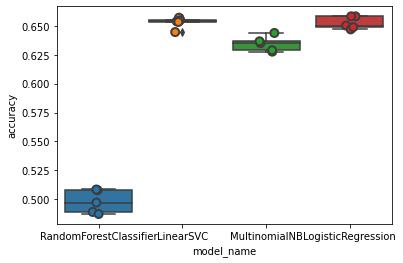

In [32]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [33]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.652855
LogisticRegression        0.652621
MultinomialNB             0.634496
RandomForestClassifier    0.497759
Name: accuracy, dtype: float64

# Best Model

In [44]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

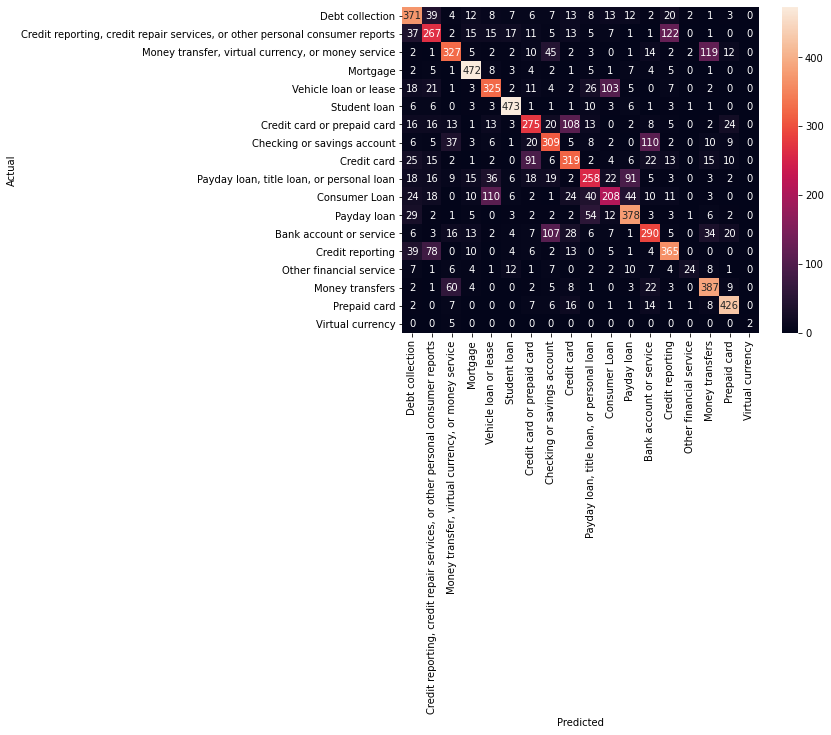

In [45]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [46]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
      print('')

'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Debt collection' : 37 examples.


Product                       Consumer_complaint_narrative
6 982034   Credit reporting, credit repair services, or o...  I have been disputing this debt with XXXX XXXX...
  628334   Credit reporting, credit repair services, or o...  I HAVE UNATHORIZED INQUIRES THAT ARE NOT RELAT...
  946961   Credit reporting, credit repair services, or o...  I have sent debt validation letters to the com...
  370619   Credit reporting, credit repair services, or o...  I Have requested five different times of the 3...
  1840455  Credit reporting, credit repair services, or o...  XXXX XXXX  amount owed XXXX, i have call XXXX ...
  985369   Credit reporting, credit repair services, or o...  XXXX XXXX in the amount of {$610.00} is reflec...
  964529   Credit reporting, credit repair services, or o...  This company sent the exact same response from...
  103846   Credit reporting, credit repair services, or o...  You need to get this XXXX off immediately as i...
  215903   Credit reporting, credit repair services, or o...  I was told by Penny Mac supervisor that they a...
  168730   Credit reporting, credit repair services, or o...  The following account should be removed from m...
  337063   Credit reporting, credit repair services, or o...  Upon viewing the result of my dispute on my cr...
  976550   Credit reporting, credit repair services, or o...  Please help CFPB and take this seriously. I ha...
  1823514  Credit reporting, credit repair services, or o...  I was called and offered a settlement on a deb...
  76445    Credit reporting, credit repair services, or o...  XXXX XXXX XXXX, XXXX Company could not validat...
  33294    Credit reporting, credit repair services, or o...  Accounts Receivable - XXXX - is reporting on m...
  1979996  Credit reporting, credit repair services, or o...  Actions taken by this company on XX/XX/XXXX XX...
  376141   Credit reporting, credit repair services, or o...  This is my second request regarding fraudulent...
  198579   Credit reporting, credit repair services, or o...  I am a victim of identity theft. The informati...
  1085368  Credit reporting, credit repair services, or o...  I disputed an account on my Credit report thro...
  384446   Credit reporting, credit repair services, or o...  On XX/XX/XXXX I sent {$20000.00} in XXXX  doll...
  450413   Credit reporting, credit repair services, or o...  As notified previously, I have been a victim o...
  66707    Credit reporting, credit repair services, or o...  ENTITY INVOLVED : CALVARY PORTFOLIO SERVICES, ...
  526342   Credit reporting, credit repair services, or o...  I have a debt from XXXX XXXX XXXX showing as c...
  1020255  Credit reporting, credit repair services, or o...  PRA purchased a debt from XXXX XXXX that shoul...
  42480    Credit reporting, credit repair services, or o...  XXXX XX/XX/2019, received letter from Wells Fa...
  120349   Credit reporting, credit repair services, or o...  XXXX XXXX engaged in an act of consumer fraud,...
  767453   Credit reporting, credit repair services, or o...  Recently while conducting a monitor of my cred...
  153774   Credit reporting, credit repair services, or o...  I send a validation letter to the credit burea...
  264300   Credit reporting, credit repair services, or o...  A person came on the line and would not listen...
  800655   Credit reporting, credit repair services, or o...  THIS IS ACTUASLLY THE SECOND CFPB REPORT I BEL...
  1914292  Credit reporting, credit repair services, or o...  I was looking over my report and I seen some c...
  769894   Credit reporting, credit repair services, or o...  I have a loan with XXXX XXXX XXXX ( Original C...
  684934   Credit reporting, credit repair services, or o...  To Whom It May Concern, The reason for my disp...
  752328   Credit reporting, credit repair services, or o...  Recently while conducting a monitor of my cred...
  1914652  Credit reporting, credit repair services, or o...  There is a derogatory mark on my credit due to...
  561970   Credit rep


'Vehicle loan or lease' predicted as 'Debt collection' : 18 examples.


Product                       Consumer_complaint_narrative
16 870212   Vehicle loan or lease  XXXX XXXX XXXX, Account # XXXX I received a le...
   1937830  Vehicle loan or lease  Again, on XX/XX/2018 XXXX XXXX XXXX submitted ...
   488522   Vehicle loan or lease  I have disputed this account and have reached ...
   761529   Vehicle loan or lease  I am requesting this investigation under the a...
   265929   Vehicle loan or lease  Please attached. This company is engaged is so...
   172317   Vehicle loan or lease  The wage garnishment is from an auto repo in X...
   146677   Vehicle loan or lease  XXXX XXXX of Larry H Miller XXXX illegally dis...
   316920   Vehicle loan or lease  Every time I am contacted by credit acceptance...
   814597   Vehicle loan or lease  This is a continuance of my previous complaint...
   1937916  Vehicle loan or lease  The interest rate is RIDICULOUS Ive never gott...
   816765   Vehicle loan or lease  On XX/XX/XXXX I received a letter from Coastal...
   1884713  Vehicle loan or lease  I purchased a XXXX XXXX XXXX on XX/XX/XXXX fro...
   1915689  Vehicle loan or lease  On XX/XX/2018 i called XXXX XXXX XXXX in regar...
   147700   Vehicle loan or lease  This complaint is in regards to file # XXXX I ...
   515172   Vehicle loan or lease  Amidst this worldwide crisis that we are facin...
   112992   Vehicle loan or lease  On XX/XX/2020 I made a payment in excess of wh...
   906175   Vehicle loan or lease  On XX/XX/XXXX I rec 'd a letter from XXXX XXXX...
   1210182  Vehicle loan or lease  In short XXXX XXXX XXXX refused to offer me a ...


'Student loan' predicted as 'Debt collection' : 6 examples.


Product                       Consumer_complaint_narrative
15 1861043  Student loan  I made a large lump sum payment in ( XX/XX/201...
   691414   Student loan  There has never been any type of consistency o...
   920287   Student loan  I spoke with a representative and she did an a...
   208593   Student loan  I have asked several times for a pay off amoun...
   1700550  Student loan  The university in which I was attending ( Univ...
   1744154  Student loan  I had a financial aid hold on my account for a...


'Credit card or prepaid card' predicted as 'Debt collection' : 16 examples.


Product                       Consumer_complaint_narrative
4 745389   Credit card or prepaid card  XXXX XXXX XXXX XXXX XXXX XXXX XXXXXXXX XXXX XX...
  339618   Credit card or prepaid card  Please be advised that I am requesting that th...
  128378   Credit card or prepaid card  CITIBANK, I sent a LEGAL Notarized affidavit d...
  518634   Credit card or prepaid card  I tried send u claims about this debt and it s...
  1023546  Credit card or prepaid card  My account was closed in 2017, i was making re...
  1870115  Credit card or prepaid card  I have had a Paypal account through XXXX XXXX ...
  406615   Credit card or prepaid card  Customer Service is extremely rude XXXX, and h...
  1833750  Credit card or prepaid card  Reopening case # XXXX and XXXX. Please note th...
  1020736  Credit card or prepaid card  I have listed all the complaints in the attach...
  203417   Credit card or prepaid card  This kind of account is placed as a charged of...
  1830355  Credit card or prepaid card  I would like to file a formal complaint agains...
  918319   Credit card or prepaid card  TODAYS DATE : XXXX/XXXX/XXXX XXXX XXXX XXXX XX...
  98403    Credit card or prepaid card  This account was settled with the collection a...
  1797108  Credit card or prepaid card  Portfolio Recovery Associates accout number # ...
  467356   Credit card or prepaid card  The collection company is Portfolio Collection...
  494805   Credit card or prepaid card  Capital One closed both of my accounts for non...


'Checking or savings account' predicted as 'Debt collection' : 6 examples.


Product                       Consumer_complaint_narrative
1 1957340  Checking or savings account  Well, I had this account and yes I am doing my...
  812385   Checking or savings account  My account balance w as discharged i n  a Chap...
  1998549  Checking or savings account  On XX/XX/2016, I had a consultation with a XXX...
  537942   Checking or savings account  I was offered and accepted overdraft coverages...
  810027   Checking or savings account  My account with Wells Fargo was overdrawn for ...
  643832   Checking or savings account  In XXXX I paid my debt to Bank of America and ...


'Credit card' predicted as 'Debt collection' : 25 examples.


Product                       Consumer_complaint_narrative
3 1612911  Credit card  I sent Bank of America a letter XXXX XXXX, XXX...
  1653885  Credit card  Continue to receive calls from unknown company...
  1622464  Credit card  On XXXX XXXX, XXXX received a call and voicema...
  1065016  Credit card  I wanted to report that a Sourh Carolina magis...
  1699872  Credit card  Good afternoon, hoping you can get this remove...
  1735279  Credit card  This is a follow up to dispute : XXXX Bank of ...
  1682585  Credit card  Debt buyer Cavalry Portfolio SPV I, LLC sued m...
  841761   Credit card  I have sent several letters asking for proof b...
  1609483  Credit card  I sent the following message to Capital One on...
  1610251  Credit card  I have disputed this account several times wit...
  1694266  Credit card  Capital One continues to pursue garnishment on...
  1672861  Credit card  XXXX autobilled ( renewed ) my subscribtion XX...
  1609688  Credit card  I have recently apply for a mortgage and I was...
  1633561  Credit card  I am received several phone calls requesting p...
  1629819  Credit card  I sent them a letter agreeing to a payment off...
  1726259  Credit card  I am writing you as a last resort to attempt t...
  1645585  Credit card  Initiated contact via written notification of ...
  1034871  Credit card  I originally had a store charge with XXXX XXXX...
  1739145  Credit card  A Letter was sent requesting validation of thi...
  1592826  Credit card  On XX/XX/2017, Syncrony Bank submitted a docum...
  1695359  Credit card  I have been been repeatedly called by alliance...
  1695607  Credit card  I have provided Identity theft Report, dispute...
  1558107  Credit card  No contract with this company as they are repo...
  1679332  Credit card  Capitol One credit card company makes collecti...
  1793914  Credit card  A few years ago I contact ed Citi bank  regard...


'Payday loan, title loan, or personal loan' predicted as 'Debt collection' : 18 examples.


Product                       Consumer_complaint_narrative
13 553506   Payday loan, title loan, or personal loan  I tried reaching out to the company numerous t...
   1865355  Payday loan, title loan, or personal loan  I used their service in XX/XX/XXXX or XX/XX/XX...
   123608   Payday loan, title loan, or personal loan  This is not a new loan. I've already paid more...
   1877888  Payday loan, title loan, or personal loan  I got an email from a loan company named XXXX....
   29569    Payday loan, title loan, or personal loan  I took out some online payday loans over a few...
   612932   Payday loan, title loan, or personal loan  Hi - I have several synchrony bank loans that ...
   1830430  Payday loan, title loan, or personal loan  AD Astra Recovery services purchased this debt...
   919923   Payday loan, title loan, or personal loan  Reflecting on credit reportXX/XX/XXXX {$630.00...
   256526   Payday loan, title loan, or personal loan  We had some expected medical expenses which ca...
   262430   Payday loan, title loan, or personal loan  I have XXXX XXXX XXXX and my income has decrea...
   61465    Payday loan, title loan, or personal loan  Company attorney claims they have tried to con...
   756974   Payday loan, title loan, or personal loan  The debt collector threatened to call my job a...
   40483    Payday loan, title loan, or personal loan  Complaining in Accordance with The Fair Debt C...
   205651   Payday loan, title loan, or personal loan  Ive tried multiple times to get an address to ...
   904844   Payday loan, title loan, or personal loan  I am two months past due - approx. {$140.00} I...
   122657   Payday loan, title loan, or personal loan  Thiscompanyisfinancinghurtingme.Ineededmoneyan...
   84946    Payday loan, title loan, or personal loan  Fraud, scam and false reporting to XXXX about ...
   1019857  Payday loan, title loan, or personal loan  First off the Company is based out of Utah and...


'Consumer Loan' predicted as 'Debt collection' : 24 examples.


Product                       Consumer_complaint_narrative
2 1709204  Consumer Loan  Debt collector is calling my job several times...
  1748938  Consumer Loan  I have never had an account with the XXXX cabl...
  1672658  Consumer Loan  Metro Collection Service, XXXX XXXX has called...
  1615834  Consumer Loan  Receiving automated phone messages from a comp...
  787041   Consumer Loan  They keep calling and calling and calling even...
  1612925  Consumer Loan  Payments were made to collection agency and th...
  1117686  Consumer Loan  Contacted by Blackrock Mitigation XXXX stating...
  1608064  Consumer Loan  I owe a debt to a creditor and went through th...
  1642082  Consumer Loan  Sunloan is posting notices on my security door...
  1061222  Consumer Loan  On XX/XX/2016 I paid the balance to Hyundai fo...
  1748572  Consumer Loan  On XXXX XXXX, I received a phone call at work ...
  1694600  Consumer Loan  they are calling my mother threatening her tha...
  1615843  Consumer Loan  Nationwide LLC continually making harassing ph...
  1739032  Consumer Loan  Harley Davidson is calling the office for debt...
  1026229  Consumer Loan  I had a collection filed on me for a loss of t...
  1731952  Consumer Loan  XXXX XXXX sent a towing company to contact us ...
  1667197  Consumer Loan  This dispute is in regards to BMW Financial Se...
  1651716  Consumer Loan  American General Finance of America , Inc. for...
  841326   Consumer Loan  I have repeatedly asked Skopos financial Not t...
  1657590  Consumer Loan  I have received calls daily from Hyundai/Kia f...
  1682485  Consumer Loan  I have an old debt that filed to attach bank a...
  1645710  Consumer Loan  The agent who called, identified herself as a ...
  1650418  Consumer Loan  I believe this company is operating a loan sca...
  1670144  Consumer Loan  Exeter Finance Corp XXXX XXXX XXXX XXXX, TX XX...


'Payday loan' predicted as 'Debt collection' : 29 examples.


Product                       Consumer_complaint_narrative
12 1616812  Payday loan  I have paid this debt 2 times and sent several...
   1063488  Payday loan  not sure what the debt is for have n't talked ...
   1646124  Payday loan  They have called me 38 times since XXXX XXXX. ...
   1693911  Payday loan  I had a missed called on XX/XX/XXXX from XXXX....
   1618743  Payday loan  Told me my account was settled and paid in ful...
   1784629  Payday loan  I get robo calls from XXXX USI Solutions , Inc...
   1690371  Payday loan  ACE CASH & lt ; XXXXXXXXXXXX XXXX XXXX ( 51 mi...
   864678   Payday loan  I am a victim of identity theft. I learned tha...
   1607814  Payday loan  I asked Greenback Recovery Group to stop calli...
   1037237  Payday loan  On XXXX XXXX received a call from a XXXX XXXX ...
   867608   Payday loan  I received a call today from a blocked number ...
   1669461  Payday loan  This debt is XXXX and has been paid. It is ill...
   1630916  Payday loan  XXXX Associates called me and stated that I ow...
   1670462  Payday loan  Someone from High Point Asset, Inc. called my ...
   1687350  Payday loan  Some years ago, I took out a payday loan. Beca...
   1659976  Payday loan  My mother got sick and all my money I gave to ...
   1649461  Payday loan  i called and talked to someone there and told ...
   1743608  Payday loan  i XXXX XXXX submitted all account to XXXX incl...
   1678911  Payday loan  Collector keeps contacting job for an employee...
   1641835  Payday loan  I am responding to your contact about collecti...
   1732724  Payday loan  I am now getting harassing emails on top of th...
   1658390  Payday loan  The charges went for {$160.00} to {$390.00} .....
   1723153  Payday loan  This activity was due to identity theft. I hav...
   1610479  Payday loan  I contacted The Bureaus to pay off a debt. The...
   1784215  Payday loan  calling and threatening me with court and comi...
   1698899  Payday loan  I received a call form XXXX County of Governme...
   1695417  Payday loan  I was in a accident and fell behind on my fina...
   1616789  Payday loan  XX/XX/2012 my apartment was robbed. They stole...
   1613168  Payday loan  Case number : XXXX This information in regards...


'Bank account or service' predicted as 'Debt collection' : 6 examples.


Product                       Consumer_complaint_narrative
0 1679424  Bank account or service     wells fargo gave me XXXX for forgives of debt.
  1741783  Bank account or service  I have been contacted by Convergent for a debt...
  1749406  Bank account or service  I am being contacted continually by 5th 3rd Ba...
  1689001  Bank account or service  In XXXX XXXX My checking account with Bank Of ...
  1622350  Bank account or service  A " law office '' contacted me saying they wer...
  1017065  Bank account or service  COMMERCIAL AFFIDAVIT OF TRUTH XX/XX/2017 1 ) B...


'Credit reporting' predicted as 'Debt collection' : 39 examples.


Product                       Consumer_complaint_narrative
5 1719177  Credit reporting  I received a letter in mail. It was a pre-appr...
  1608871  Credit reporting  XXXX XXXX AKA XXXX XXXX is reporting to my cre...
  1632333  Credit reporting  Friendly foot care submitted payment to the wr...
  1603089  Credit reporting  there is a collection account on my credit rep...
  747293   Credit reporting  I had paid off an apartment collection from 3 ...
  1654759  Credit reporting  A company called XXXX has filed a negative ite...
  1666896  Credit reporting  The open collections notice was never received...
  1715210  Credit reporting  I have disputed this through all XXXX credit a...
  1628481  Credit reporting  XXXX XXXX XXXX Account showing up as a collect...
  985988   Credit reporting  I just found a multiple applied to different c...
  1724931  Credit reporting  Hello, this is a supplement to my complaint ea...
  1662510  Credit reporting  I have a bunch of medical collections on all X...
  1720532  Credit reporting  This is in regards to XXXX XXXX XXXX XXXX XXXX...
  1715988  Credit reporting  Recently, I notice a collection from XXXX XXXX...
  1704974  Credit reporting  XXXX credit services who is a XXXX party debt ...
  1737136  Credit reporting  Credit report is showing I owe {$68.00} to XXX...
  1744423  Credit reporting  XXXX XXXX XXXX ( XXXX ) placed a collections a...
  1691618  Credit reporting  I had a hospital visit where I saw several spe...
  1698275  Credit reporting  Notice an paid in full but still open account ...
  1646165  Credit reporting  Sent creditor copy of discharge notice but hav...
  1636106  Credit reporting  My social has been used, so I would like to ge...
  1745024  Credit reporting  I have a collection from an apartment complex ...
  1622985  Credit reporting  I have a judgment on my credit report from XXX...
  1647986  Credit reporting  I am writing in response to Collection XXXX be...
  1035236  Credit reporting  I have been disputing a debt for verification ...
  1746586  Credit reporting  Consolidated Recovery System is reporting coll...
  1035294  Credit reporting  The company National Fitness has a gym account...
  1789140  Credit reporting  There is a collection from XXXX XXXX stating a...
  1714121  Credit reporting  I had been wrongfully billed from a hospital b...
  853984   Credit reporting  I was checking my credit score and had seen th...
  1726081  Credit reporting  Was with cell carrier XXXX for several years a...
  1726554  Credit reporting  Placed judgement on my credit report, after I ...
  1611265  Credit reporting  XXXX sold my debt to XXXX management. I fell b...
  1624030  Credit reporting  This account was paid and closed and Is showin...
  1025084  Credit reporting  I recently opened up a dispute with Experian r...
  1659095  Credit reporting  My legal name was not documented or mistakenly...
  1739900  Credit reporting  This is for wrongful information on my credit ...
  1684566  Credit reporting  XXXX says I owe them money ; I do n't believe ...
  873445   Credit reporting  jh portfolios re-inserted a old deleted fraudu...


'Other financial service' predicted as 'Debt collection' : 7 examples.


Product                       Consumer_complaint_narrative
11 1713489  Other financial service  Returned check amounts for XXXX are showing as...
   739586   Other financial service  Cornerstone Legal Group , LLC XXXX XXXX XXXX X...
   1060935  Other financial service  I find that this company, Riverwalk Debt Solut...
   1602970  Other financial service  Contract is misleading advising you can get a ...
   1703084  Other financial service  I have just started with Clear One Advantage a...
   1691696  Other financial service  Nicholes Financial Inc is reporting a Charged ...
   1978511  Other financial service  We signed up for ClearOne Advantage to handle ...


'Debt collection' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 39 examples.


Product                       Consumer_complaint_narrative
7 451737   Debt collection  Listed as COLLECTION Collection/Chargeoff new ...
  1904161  Debt collection  XXXX 's showed up on my credit acct number XXX...
  296774   Debt collection  This debt was deleted off of my credit report ...
  1973641  Debt collection  Equifax on XX/XX/2018 I file with the CFPB a c...
  429640   Debt collection  this company committed the HIPPA violation Who...
  687494   Debt collection  On XX/XX/2016 IQ Data International added a de...
  563588   Debt collection  After reviewing my credit profile on XX/XX/202...
  1371467  Debt collection  XX/XX/XXXX - Received phone call from NCC Busi...
  1704492  Debt collection  I need your assistance in helping me to get se...
  984968   Debt collection  LVNV FUNDING has been non-compliant with remov...
  213332   Debt collection  I was contacted by XXXX XXXX XXXX on XX/XX/202...
  350500   Debt collection  best buy/ cbna is reporting on my credit repor...
  705885   Debt collection  To Whom it may concern, I recently challenged ...
  150441   Debt collection  I NOTICED ON MY CREDIT REPORT A CLOSED ACCOUNT...
  95424    Debt collection  Grant Mercantile Agency and the credit bureaus...
  126444   Debt collection  Lviv account number XXXX XXXX date XXXX XXXX X...
  1123053  Debt collection  There shouldn’t be anything on my credit as I ...
  1913535  Debt collection  I went to a seminar on XX/XX/2015 called " XXX...
  436335   Debt collection  i recently obtain my credit report due to covi...
  835123   Debt collection  Southwest Credit sent me notification of a {$8...
  262242   Debt collection  I was and am i victim of cyber attacks cyber c...
  1010906  Debt collection  Chapter XXXX bankruptcy being reported I have ...
  779339   Debt collection  Someone opened a utility bill in my name. I di...
  401365   Debt collection  Hello, Both accounts are passed the 7 year mar...
  1064780  Debt collection  I would like to request another investigation....
  921833   Debt collection  I have contested a XXXX dollar bill with the c...
  1668060  Debt collection  Paramount Recovery Systems has put amounts of ...
  1022387  Debt collection  Today I spoke with XXXX XXXX who was really ru...
  1630501  Debt collection  Hello, I 'm extremely upset. I settled the deb...
  54354    Debt collection  Hi, I was actually talking to a representative...
  240831   Debt collection  recently obtain a copy of my credit report and...
  1018285  Debt collection  I am a victim of victim of identity theft and ...
  812978   Debt collection  I am a victim of identity. Someone has obtaine...
  1798292  Debt collection  XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXXN ...
  1002645  Debt collection  I have contacted XXXX XXXX XXXX regarding Acco...
  821771   Debt collection  Debt not mine. It is showing up Wakefield and ...
  292178   Debt collection  I am very disappointed in Experian for this is...
  538235   Debt collection  I sent a dispute letter to Security Credit Ser...
  1611000  Debt collection  CREDIT MANAGEMENT debt practices have notified...


'Vehicle loan or lease' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 21 examples.


Product                       Consumer_complaint_narrative
16 432228   Vehicle loan or lease  I entered into my lease contract in XX/XX/XXXX...
   853389   Vehicle loan or lease  This pertains to the complaint # that XXXX was...
   31151    Vehicle loan or lease  My credit was used in a fraudulent transaction...
   248965   Vehicle loan or lease  Exeter Finance has made incorrect reports on t...
   382175   Vehicle loan or lease  on XX/XX/2019 XXXX removed what was agreed to ...
   925820   Vehicle loan or lease  The account with XXXX XXXX XXXX XXXX in the am...
   1930654  Vehicle loan or lease  XXXX XXXXXXXX XXXX reported that I was 30 days...
   1792218  Vehicle loan or lease  There was a late payment made on the account, ...
   1197037  Vehicle loan or lease  My attorney received a letter from XXXX  on XX...
   1962589  Vehicle loan or lease  Denied credit basis for denial was not valid s...
   1835680  Vehicle loan or lease  Credit Acceptance corporation as a collection ...
   191150   Vehicle loan or lease  I have reached out to Santander Bank 4 times t...
   1944160  Vehicle loan or lease  I have reached out 3 times by email to the com...
   477840   Vehicle loan or lease  My identity has been seriously compromised by ...
   1083140  Vehicle loan or lease  The early part of XXXX GM financial mailed out...
   828132   Vehicle loan or lease  Westlake Financial is reporting and has report...
   600247   Vehicle loan or lease  Dear sir, I have purchased a brand new XXXX mo...
   992368   Vehicle loan or lease  I went to a XXXX dealership in XXXX, FL in 201...
   514726   Vehicle loan or lease  On XX/XX/2020 someone without my authorization...
   226317   Vehicle loan or lease  Lease amount has been paid in full. Incorrect ...
   1845413  Vehicle loan or lease  I disputed a late payment on my credit report ...


'Student loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 6 examples.


Product                       Consumer_complaint_narrative
15 784405   Student loan  I have several accounts which are still report...
   807450   Student loan  In XX/XX/XXXX, I wrote a letter to Navient ask...
   1034127  Student loan  Account shows late payments that are not accur...
   1697521  Student loan  Fed Loan Servicing is currently reporting fals...
   254159   Student loan  There are inaccuracies on my credit file that ...
   749607   Student loan  I took out this loan back in XXXX to attend co...


'Credit card or prepaid card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 16 examples.


Product                       Consumer_complaint_narrative
4 880061   Credit card or prepaid card  In XXXX of 2019 US bank offered a one time pay...
  181466   Credit card or prepaid card  I was shocked when I reviewed my credit report...
  1005014  Credit card or prepaid card  The text message was received from XXXX number...
  619594   Credit card or prepaid card  The main reason for writing this is to request...
  391363   Credit card or prepaid card  On XXXX, XXXX I realized that I am a victim of...
  1879381  Credit card or prepaid card  Im writing you this letter to inform you that ...
  1947913  Credit card or prepaid card  XXXX has been non-compliant with removing the ...
  466491   Credit card or prepaid card  Hi and how are you doing? Im not sure who to t...
  84812    Credit card or prepaid card  While applying for a credit card offer with Ci...
  1941279  Credit card or prepaid card  XXXX has been non-compliant with removing the ...
  1885563  Credit card or prepaid card  I left the country and moved to XXXX in XXXX. ...
  875168   Credit card or prepaid card  This company XXXX wanted to check my credit re...
  718480   Credit card or prepaid card  usbankreliacard : Unresponsive to telephone in...
  1996900  Credit card or prepaid card  USPS XXXX XX/XX/18 {$110.00} XXXX XXXX # XXXX ...
  582556   Credit card or prepaid card  I have been recently informed that there is ne...
  845338   Credit card or prepaid card  I applied for the Wells Fargo / XXXX XXXX card...


'Credit card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 15 examples.


Product                       Consumer_complaint_narrative
3 1618617  Credit card  Discover Card XXXX. XXXX XXXX XXXX XXXX, OH XX...
  1693863  Credit card  A credit card I had not requested supplied inc...
  1657100  Credit card  Today on XXXX XXXX/XXXX/2016 i saw an inquiry ...
  772165   Credit card  I have reached out to this company on numerous...
  1711459  Credit card  XX/XX/XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX ...
  1742810  Credit card  The Legal entity ( GECRB HBC ) is reporting ne...
  1746500  Credit card  I have been a customer of DINERS CLUB for the ...
  1633100  Credit card  Capital One is reporting an account on my cred...
  1735252  Credit card  I have an open account with HSBC Bank, which w...
  1738083  Credit card  I am a victim of credit card fraud or identity...
  1682952  Credit card  Listed on my credit report under adverse accou...
  1743295  Credit card  FIA is incorrectly reporting a late payment of...
  1717701  Credit card  Paypal has reported me late and I have made pa...
  1653656  Credit card  Capital One is FRAUD! I have contacted them in...
  1741687  Credit card  SYNCB, has continue to report outdated informa...


'Payday loan, title loan, or personal loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 16 examples.


Product                       Consumer_complaint_narrative
13 341178   Payday loan, title loan, or personal loan  Tower Loan has been running hard inquiries on ...
   1956155  Payday loan, title loan, or personal loan  Past Complaint # : XXXX XXXX, ONLINE PAYDAY AD...
   711086   Payday loan, title loan, or personal loan  When I looked at my online account balance on ...
   701413   Payday loan, title loan, or personal loan  My identity has been seriously compromised by ...
   325060   Payday loan, title loan, or personal loan  Lending Clubs customer service representatives...
   99616    Payday loan, title loan, or personal loan  Request of terms, rules, agreements with vario...
   156911   Payday loan, title loan, or personal loan  The Phantom Debt Collector Scheme is what happ...
   1797429  Payday loan, title loan, or personal loan  On XXXX XXXX, XXXX I sent Prosper a voided che...
   1021341  Payday loan, title loan, or personal loan  I disputed the account on my credit reports .....
   961723   Payday loan, title loan, or personal loan  I obtained a loan through Synchrony bank to pu...
   141295   Payday loan, title loan, or personal loan  Account was charge without permission as well ...
   788155   Payday loan, title loan, or personal loan  I had contacte d Cash Call in order to shop ra...
   837279   Payday loan, title loan, or personal loan  I am writing in reference to a negative pay st...
   339330   Payday loan, title loan, or personal loan  We opened an account with conns and when we re...
   844616   Payday loan, title loan, or personal loan  They sent me a letter with some information th...
   58983    Payday loan, title loan, or personal loan  The lender charges us usurious interest rates ...


'Consumer Loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 18 examples.


Product                       Consumer_complaint_narrative
2 1700849  Consumer Loan  This is a notice to cease unauthorized inquire...
  1602765  Consumer Loan  There are numerous inconsistencies and discrep...
  1734347  Consumer Loan  A previous complaint was filed against Argon C...
  1749248  Consumer Loan  FIFTH THIRD BANK-XXXX. XXXX XXXX XXXX MD XXXX,...
  1739053  Consumer Loan  I am writing to submit a complaint about unfai...
  1617055  Consumer Loan  While reviewing my XXXX credit report, I notic...
  1720180  Consumer Loan  We made arrangements to pay the account curren...
  1666364  Consumer Loan  I disputed an account with Chase Auto Finance ...
  1707550  Consumer Loan  Inaccurate information being reported to credi...
  1735521  Consumer Loan                  There is an unauthorized inquiry.
  1656461  Consumer Loan  I was called on XXXX XXXX to make payment -at ...
  1707930  Consumer Loan  Mercedes Financial has been reporting incorrec...
  1686282  Consumer Loan  PNC is reporting an account on my credit repor...
  1795703  Consumer Loan  My XXXX credit report shows an unauthorized cr...
  1693134  Consumer Loan  On XXXX/XXXX/15 I went online to research car ...
  1696027  Consumer Loan  I just pulled my credit report and Hyundai Mot...
  1702007  Consumer Loan  Acct # XXXX XXXX balance was paid. Inaccurate ...
  1793610  Consumer Loan  I got a loan from  rooms to go th e bank that ...


'Credit reporting' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 78 examples.


Product                       Consumer_complaint_narrative
5 1639619  Credit reporting                    I am a victim of identity theft
  1617586  Credit reporting  I have several accounts that are listed with t...
  1642688  Credit reporting  I have disputed with this credit bureau severa...
  1663662  Credit reporting  This complaint is per your offices request I a...
  1670073  Credit reporting  I bankruptcy was dismissed in XXXX 2010. Would...
...                     ...                                                ...
  1628728  Credit reporting       Credit report shows I am XXXX, and I am not.
  1680704  Credit reporting  I have worked with the credit reporting agency...
  1795651  Credit reporting  I am going through a divorce currently and was...
  1690083  Credit reporting  Id like to file a consumer report. There is an...
  1062142  Credit reporting  I received a credit inquiry alert from Experia...

[78 rows x 2 columns]


'Credit card or prepaid card' predicted as 'Money transfer, virtual currency, or money service' : 13 examples.


Product                       Consumer_complaint_narrative
4 854570   Credit card or prepaid card  Hello, Yesterday ( XXXX ) afternoon, around XX...
  238939   Credit card or prepaid card  On XXXX my XXXX Prepaid Debit card ending in X...
  639180   Credit card or prepaid card  Its been 5 weeks going on six and I still have...
  914591   Credit card or prepaid card  PayPal used my credit card to pay XXXX {$100.0...
  1842130  Credit card or prepaid card  I normally pay my XXXX  XXXX XXXX online throu...
  88355    Credit card or prepaid card  I paid my Macy 's credit card on XX/XX/2018 th...
  304473   Credit card or prepaid card  In XXXX I used my Apple Card to buy an XXXX. I...
  155522   Credit card or prepaid card  Mr. & Mrs. XXXX XXXX XXXX XXXX XXXX XXXX XXXX ...
  479660   Credit card or prepaid card  on XX/XX/XXXX I received it at midnight I rece...
  250551   Credit card or prepaid card  On XX/XX/XXXX XXXX released a refund in the am...
  363019   Credit card or prepaid card  I noticed an unfamiliar transaction ( # XXXX )...
  91776    Credit card or prepaid card  A dispute for {$64.00} was denied by PayPal ev...
  1999693  Credit card or prepaid card  " I have an overcharge of {$250.00} on my curr...


'Checking or savings account' predicted as 'Money transfer, virtual currency, or money service' : 37 examples.


Product                       Consumer_complaint_narrative
1 117864   Checking or savings account  I have reached out to Huntington Bank multiple...
  1906195  Checking or savings account  On XX/XX/XXXX, my son sent {$2000.00}. from a ...
  1820745  Checking or savings account  I checked my balance late XXXX on XX/XX/XXXX, ...
  1896901  Checking or savings account  DATE OF TRANSACTION : XX/XX/2018 TRANSACTION A...
  114131   Checking or savings account  Had a previous complaint # XXXX concerning HSB...
  597872   Checking or savings account  Ever since TD went to an automated system rega...
  599338   Checking or savings account  Dear CFPB Representative, XXXX XX/XX/2020 I re...
  261763   Checking or savings account  I have tried connecting my onc account to my b...
  685112   Checking or savings account  I am trying to link my PNC bank checking accou...
  1812311  Checking or savings account  Since middle of the month of XX/XX/XXXX, Sun T...
  267048   Checking or savings account  A so called friend of mine asked if I could he...
  350716   Checking or savings account  I was given a Comdata Debit Card by my employe...
  76058    Checking or savings account  For my account XXXX, they sent the remaining {...
  281308   Checking or savings account  Was trying to link my account to XXXX XXXX and...
  164879   Checking or savings account  On XX/XX/XXXX, I deposited the paper check iss...
  192171   Checking or savings account  On XXXX XXXX, person or persons unknown used m...
  680587   Checking or savings account  An individual accessed my online banking attem...
  1022409  Checking or savings account  I received the sum of {$8200.00} in my checkin...
  332726   Checking or savings account  As of XXXX XX/XX/XXXX Axos bank ( XXXX ) are h...
  803766   Checking or savings account  On  XXXX   XXXX ,  2017  I received an email f...
  137265   Checking or savings account  On XX/XX/2019 I sent a wire transfer from my C...
  318179   Checking or savings account  I would like to have my investment application...
  254392   Checking or savings account  I've had it with square! They literally go out...
  804020   Checking or savings account  I use an app callled   XXXX   XXXX   it 's kin...
  1933315  Checking or savings account  On XX/XX/XXXX I submitted to Capital One Bank ...
  818632   Checking or savings account  An account holder at  XXXX , took funds illega...
  447427   Checking or savings account  TD account number : XXXX TD debit card number ...
  677641   Checking or savings account  Unable to verify or connect pnc account to oth...
  798380   Checking or savings account  On XX/XX/XXXX I withdraw {$1000.00} from XXXX ...
  712682   Checking or savings account  I'm unable to connect my account with an inves...
  459066   Checking or savings account  I need to link my account with my XXXX XXXX XX...
  552660   Checking or savings account  On XX/XX/XXXX, my kid got my cell phone accide...
  943335   Checking or savings account  TD BANK Blocking me from enabling external app...
  782184   Checking or savings account  The banks new firearm policies recently enacte...
  907724   Checking or savings account  Been trying to Transfer information from JPMOR...
  827064   Checking or savings account  today on thursday XX/XX/XXXX i tried to wire m...
  867536   Checking or savings account  Attempt to send my $ to XXXX - denied. \n\nI c...


'Payday loan, title loan, or personal loan' predicted as 'Money transfer, virtual currency, or money service' : 9 examples.


Product                       Consumer_complaint_narrative
13 6091     Payday loan, title loan, or personal loan  I met someone online 5 months ago and it was n...
   271986   Payday loan, title loan, or personal loan  I am trying to connect my Pnc account to my XX...
   547776   Payday loan, title loan, or personal loan                   PNC wont let me link my account.
   184864   Payday loan, title loan, or personal loan  On XX/XX/2019 zocaloans debted XXXX from my ac...
   458462   Payday loan, title loan, or personal loan  I requested two " instacash '' advances totall...
   809410   Payday loan, title loan, or personal loan  I asked for a cash out of {$50.00} on X/XX/17 ...
   775861   Payday loan, title loan, or personal loan  Reference is made to Account Number XXXX for t...
   1809549  Payday loan, title loan, or personal loan  like most Americans should be, I find it distu...
   160564   Payday loan, title loan, or personal loan                            PNC XXXX let me connect


'Bank account or service' predicted as 'Money transfer, virtual currency, or money service' : 16 examples.


Product                       Consumer_complaint_narrative
0 1627112  Bank account or service  I was searching to buy a car at local dealersh...
  1697245  Bank account or service  I am in attempt of XXXX XX/XX/XXXX and my recr...
  1661995  Bank account or service  My client, XXXX XXXX, has an account at XXXX i...
  1641129  Bank account or service  I was forced to deposit & wire to multiple amo...
  1655904  Bank account or service  Opened a Simple account XX/XX/2016, linked my ...
  1386387  Bank account or service  Capital One has been unwilling or unable to pr...
  1669457  Bank account or service  I was purchasing a home care company called XX...
  1741561  Bank account or service  Hello, I use to have an account with Capital O...
  1709245  Bank account or service  Simple Bank itself is a great idea, the execut...
  1675944  Bank account or service  Bank of America has a wire transfer glitch whe...
  1643617  Bank account or service  I am filing this complaint because Paypal rest...
  1651864  Bank account or service  Last year, I finished my unfinished basement. ...
  1677724  Bank account or service  Today I had a fraudulent charge on my PayPal a...
  1727797  Bank account or service  I opened a bank account with Wells Fargo about...
  1712682  Bank account or service  After the death of my mother, I was forced to ...
  1795720  Bank account or service  FRAUD CLAIM TO SFPD, FBI, BoFA, XXXX 's Office...


'Other financial service' predicted as 'Money transfer, virtual currency, or money service' : 6 examples.


Product                       Consumer_complaint_narrative
11 1665298  Other financial service  Hello, I had processed a moneygram for a perso...
   1035990  Other financial service  I deposited traveler checks at Bank of America...
   1738589  Other financial service  During my last vacation, that I spent in XXXX,...
   1657424  Other financial service  I purchased a MoneyGram Money Order for {$400....
   1722653  Other financial service  I was purchasing services from an XXXX seller ...
   1706923  Other financial service  Reference Case # XXXX The XXXX money orders th...


'Money transfers' predicted as 'Money transfer, virtual currency, or money service' : 60 examples.


Product                       Consumer_complaint_narrative
9 1621049  Money transfers  In XX/XX/XXXX I used my XXXX credit card to pa...
  1066182  Money transfers  I reached out to Venmo because there was an un...
  1731339  Money transfers  I made a wire transfer through Citibank to XXX...
  1686304  Money transfers  I submitted a ad on XXXX for a XXXX ticket tha...
  1682372  Money transfers  I became friends with a gentlemen I met on XXX...
  1678486  Money transfers  I ordered an XXXX Watch online from an online ...
  1992934  Money transfers  My name is XXXX and I have been doing transact...
  1725703  Money transfers  On XX/XX/XXXX, I asked a friend of mine if she...
  1676447  Money transfers  I was scammed by another Bank of America clien...
  1784384  Money transfers  My mother sent me money from her Wells Fargo B...
  1629562  Money transfers  I have sent in total {$800.00} Venmo. Venmo ca...
  1721657  Money transfers  On XX/XX/2016 I transferred payment to XXXX XX...
  1720218  Money transfers  My account with Paypal was closed on XXXX XXXX...
  1643289  Money transfers  A tenant was attempting to pay rent through th...
  776416   Money transfers  For more than a year ( since  XXXX    XXXX   i...
  878931   Money transfers  I transfer my Money from City Bank on XX/XX/20...
  1623265  Money transfers  I transferred funds from my TD Bank in the U.S...
  1617153  Money transfers  This is about PayPal " Wallet ''. It allows cu...
  1747293  Money transfers  It all started with buying a condo. It 's my f...
  1707689  Money transfers  I filled out a house rental application and re...
  1731081  Money transfers  They Violated My Consumer Rights by with holdi...
  1063635  Money transfers  I sent a mobile payment of {$1000.00} via emai...
  1064858  Money transfers  My bookkeeper notified me to an unknown transf...
  1737747  Money transfers  I sold a couch for {$190.00} and received paym...
  1994598  Money transfers  I opened an account with Skrill ( https : //ww...
  1652478  Money transfers  I recently ( today ) had to make an online tra...
  1631187  Money transfers  I requested Bank of America to refund me {$160...
  1637168  Money transfers  Subscription service was cancelled with mercha...
  1757784  Money transfers  On XXXX XXXX, 2017 my attorney in XXXX XXXX wi...
  1665303  Money transfers  I was scammed by a company recruiter into send...
  1784502  Money transfers  XXXX XXXX VIOLATED THE DODD-FRANK ACT ON ME AN...
  774777   Money transfers  This guy I found online on XXXX I found a gami...
  773386   Money transfers  In regards to case XXXX Paypal has locked me o...
  1722560  Money transfers  My husband had a contract in XXXX, on his way ...
  1633728  Money transfers  After being a member of PayPal for 6+ years at...
  771439   Money transfers  Hi, I remitted money through ach to my XXXX ac...
  1616060  Money transfers  I 'm selling a Minivan on XXXX, and guy text a...
  1696869  Money transfers  I am still discriminating and totally ignored ...
  1696238  Money transfers  I submitted {$380.00} to an XXXX XXXX who clai...
  1706524  Money transfers  Discrimination and loss of money by Chase Bank...
  1702228  Money transfers  I hired a wedding planner in the XXXX - Vals W...
  1748297  Money transfers  I tried to close my Paypal account. PAYPAL sai...
  773723   Money transfers  I purchased a pair of " Authentic XXXX XXXX XX...
  1698081  Money transfers  On XXXX, XXXX, and finally on XXXX I attempted...
  1720502  Money transfers  I transferred XXXX USD through JPM CHASE on XX...
  1694010  Money transfers  When I moved from the XXXX to the USA, I was i...
  1683501  Money transfers  During a real estate transaction, our law firm...
  1742004  Money transfers  Funds were sent from my Venmo account erroneou...
  1707900  Money transfers  I made an international wire with my bank Sunt...
  777872   Money transfers  my issue is with paypal credit. 1 ) I do not g...
  1730303  Money transfers  I want to com


'Prepaid card' predicted as 'Money transfer, virtual currency, or money service' : 7 examples.


Product                       Consumer_complaint_narrative
14 1729444  Prepaid card  My account was closed and I am still waiting f...
   1742006  Prepaid card  I have a {$5.00} charge on my XXXX. This was m...
   1714001  Prepaid card  I filed a dispute in XX/XX/XXXX it is not XX/X...
   1694039  Prepaid card  Paypal took action to close my account but ref...
   1682410  Prepaid card  Paypal took action to close my account but ref...
   1647843  Prepaid card  All of a sudden I started to receive texts abo...
   1714466  Prepaid card  Google Wallet suspended my account for fraud. ...


'Debt collection' predicted as 'Mortgage' : 12 examples.


Product                       Consumer_complaint_narrative
7 1826062  Debt collection  In XX/XX/XXXX there was a devastating fire in ...
  1561467  Debt collection  The option I needed under false statements or ...
  1647686  Debt collection  This is Part XXXX of case number XXXX.SunTrust...
  974637   Debt collection  I spoke with this company multiple times. They...
  834749   Debt collection  On XX/XX/XXXX, 2017 I provided notice of my br...
  601243   Debt collection  For some reasons, my mortgage was transferred ...
  546239   Debt collection  By letter response dated XX/XX/XXXX and enclos...
  1627088  Debt collection  Loan was a home I purchased in XXXX XXXX NV. L...
  520087   Debt collection  In my opinion, the Statute of Limitations bega...
  55055    Debt collection  I recently submitted a complaint to the CFPB i...
  78141    Debt collection  I filed for bankruptcy chapter XXXX on XX/XX/X...
  893294   Debt collection  I was received a letter from XXXX XXXX XXXX fo...


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Mortgage' : 15 examples.


Product                       Consumer_complaint_narrative
6 432643   Credit reporting, credit repair services, or o...  In XX/XX/XXXX I called XXXX XXXX Loans to inqu...
  357326   Credit reporting, credit repair services, or o...  US DEPT OF EDUCATION/XXXX  XX/XX/XXXX = Closed...
  195873   Credit reporting, credit repair services, or o...  XXXX has been the worst mortgage company by fa...
  482315   Credit reporting, credit repair services, or o...  Bank of America reportedly announced me as gui...
  522102   Credit reporting, credit repair services, or o...  The Credit Bureau is reporting a business acco...
  673036   Credit reporting, credit repair services, or o...  My mortgage is currently serviced by XXXX XXXX...
  606961   Credit reporting, credit repair services, or o...  I communicated with Mercedes Benz Financial Se...
  757945   Credit reporting, credit repair services, or o...  There is an item on my credit report, a late p...
  1030949  Credit reporting, credit repair services, or o...  After my divorce was finalized on XX/XX/XXXX a...
  476192   Credit reporting, credit repair services, or o...  My husband and I were granted a loan modificat...
  1901876  Credit reporting, credit repair services, or o...  Couple different items occurred with XXXX XXXX...
  293482   Credit reporting, credit repair services, or o...  PNC receives my mortgage payment every month, ...
  971287   Credit reporting, credit repair services, or o...  XXXX XXXX XXXX ( " XXXX '' ) serviced our mort...
  969303   Credit reporting, credit repair services, or o...  Court ordered to refinance because of a divorc...
  523742   Credit reporting, credit repair services, or o...  I am super frustrated, this is my 3rd complain...


'Payday loan, title loan, or personal loan' predicted as 'Mortgage' : 15 examples.


Product                       Consumer_complaint_narrative
13 443578   Payday loan, title loan, or personal loan  RE-Wells Fargo Accounts >Personal Loan ACCT # ...
   1366340  Payday loan, title loan, or personal loan  We received a confirmation letter on  XXXX / X...
   1010829  Payday loan, title loan, or personal loan  On  XXXX , I signed a contract with  XXXX   XX...
   994886   Payday loan, title loan, or personal loan  I called XXXX XXXX in response to their consta...
   518294   Payday loan, title loan, or personal loan  I filed Chapter XXXX Bankruptcy on XX/XX/XXXX ...
   1911488  Payday loan, title loan, or personal loan  XXXX XXXX amount Financed {$3800.00} for Total...
   102654   Payday loan, title loan, or personal loan  IMPORTANT : THIS IS NOT A NEW COMPLAINT. INSTE...
   582197   Payday loan, title loan, or personal loan  I got a home equity line of credit with TDBank...
   1983685  Payday loan, title loan, or personal loan  XX/XX/XXXX-my husband and I took out a home eq...
   390881   Payday loan, title loan, or personal loan  In XXXX, XXXX, I agreed to purchase solar pane...
   1835022  Payday loan, title loan, or personal loan  On XXXX XXXX, XXXX, XXXX Montana AAG Vice  Pre...
   281819   Payday loan, title loan, or personal loan  On XX/XX/XXXX a property was mortgaged by borr...
   1972554  Payday loan, title loan, or personal loan  MUFG Union Bank Acct # XXXX : XX/XX/XXXX Compl...
   795089   Payday loan, title loan, or personal loan  Chase g ave me  a Tax Year   XX/XX/XXXX Form  ...
   121092   Payday loan, title loan, or personal loan  Per State if Georgia, this loan was done ILLEG...


'Consumer Loan' predicted as 'Mortgage' : 10 examples.


Product                       Consumer_complaint_narrative
2 1622748  Consumer Loan  I need some help, back in XX/XX/XXXX a loan th...
  1654484  Consumer Loan  I hired a law firm in XXXX 2013 because XXXX w...
  773393   Consumer Loan  I sent a letter asking them not to call my hom...
  845100   Consumer Loan  Secured a LOAN, was given a bank check issued ...
  1747018  Consumer Loan  XXXX XXXX, XXXX Consumer Financial Protection ...
  1678559  Consumer Loan  Hello, I have recently inquired about transfer...
  1626347  Consumer Loan  XXXX Home Loans Manager Vice President NMLS ID...
  1692186  Consumer Loan  Now that the CFPB is proud of solving XXXX XXX...
  1651097  Consumer Loan  we purchased our home in XXXX, due to health i...
  1709999  Consumer Loan  I have made my payments of {$670.00} on time o...


'Bank account or service' predicted as 'Mortgage' : 13 examples.


Product                       Consumer_complaint_narrative
0 1673134  Bank account or service  In XXXX, Bank of America offered us specialize...
  1610074  Bank account or service  On or about XXXX XXXX, 2016 I received a lette...
  1621881  Bank account or service  I have an executed agreement to purchase a hom...
  1738179  Bank account or service  Hi, I was Included into this, XXXX XXXX Zions ...
  1737777  Bank account or service  1. The National Bank of Arizona in XXXX, Arizo...
  1786956  Bank account or service  I went to work on XX/XX/2017 like it was a nor...
  1658269  Bank account or service  I have set up a pay my bill with XXXX XXXX to ...
  1749870  Bank account or service  Bank of America is reporting debt balance as d...
  777992   Bank account or service  WE have a loan with Champion Mortgage, XXXX Mi...
  1727799  Bank account or service  I applied for a home mortgage with Wells Fargo...
  1617079  Bank account or service  XXXX XXXX Dear Consumer Financial Protection, ...
  1693428  Bank account or service  I have notice over and over again my accoutn b...
  1646000  Bank account or service  Commercial realty loan complaint against CITIB...


'Credit reporting' predicted as 'Mortgage' : 10 examples.


Product                       Consumer_complaint_narrative
5 1658504  Credit reporting  Credit report disputed but no written resoluti...
  1793486  Credit reporting  In  XXXX , I took out a second mortgage from  ...
  1701896  Credit reporting  I purchased the home at XXXX XXXX XXXX XXXX in...
  1687017  Credit reporting  " I would like to formally dispute the way XXX...
  1686601  Credit reporting  XXXX XXXX XXXX falsely reporting on my credit ...
  1730251  Credit reporting  My name is XXXX XXXX XXXX and my wife is XXXX ...
  1708745  Credit reporting  I did not get a mortgage loan from XXXX conven...
  1738629  Credit reporting  Today I was in contact with PennyMac Loan comp...
  1691754  Credit reporting  XXXX previous CFPB complaints for the same iss...
  1734059  Credit reporting  Hello- We were the victims of XXXX and subsequ...


'Debt collection' predicted as 'Vehicle loan or lease' : 8 examples.


Product                       Consumer_complaint_narrative
7 937285   Debt collection  I have been attempting to ask XXXX XXXX XXXX  ...
  300486   Debt collection  On XX/XX/20 & XX/XX/20 I sent Formal Complaint...
  325923   Debt collection  Consumer Portfolio continues to furnish data o...
  1847524  Debt collection  On Saturday, XX/XX/2018, I paid off two auto l...
  998122   Debt collection  Had an account with XXXX XXXX radio since I bo...
  1733500  Debt collection  XXXX XXXX XXXX XXXX XXXX XXXX XXXXXXXX XXXX NA...
  589410   Debt collection  The company sent me a letter stating that they...
  1895089  Debt collection  Global Radius Solutions, call me and advised t...


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Vehicle loan or lease' : 15 examples.


Product                       Consumer_complaint_narrative
6 483249   Credit reporting, credit repair services, or o...  LexisNexis is reporting for a long time now an...
  1868478  Credit reporting, credit repair services, or o...  I filed a complaint about Santander consumer a...
  1855292  Credit reporting, credit repair services, or o...  All these companies that I had highlighted was...
  3363     Credit reporting, credit repair services, or o...  Original complaint # XXXX XX/XX/XXXX I purchas...
  892063   Credit reporting, credit repair services, or o...  On XX/XX/XXXX I scheduled a payment to XXXX XX...
  1845199  Credit reporting, credit repair services, or o...  I opened the account in XX/XX/XXXX and signed ...
  1372470  Credit reporting, credit repair services, or o...  GM Financial is incorrectly reporting late pay...
  475798   Credit reporting, credit repair services, or o...  Santander USA has lost a lawsuit which alleged...
  342203   Credit reporting, credit repair services, or o...  I have not received confirmation not certified...
  1831336  Credit reporting, credit repair services, or o...  Public record inaccurate. My personal informat...
  260345   Credit reporting, credit repair services, or o...  I was recently going to check out a new car at...
  516637   Credit reporting, credit repair services, or o...  XXXX car was purchased, XXXX car was stolen, X...
  1909320  Credit reporting, credit repair services, or o...  here are inquires that i dont recognize nor di...
  550414   Credit reporting, credit repair services, or o...  My payment with Ally financial is due on the X...
  1959113  Credit reporting, credit repair services, or o...  I returned the lease vehicle to the dealership...


'Mortgage' predicted as 'Vehicle loan or lease' : 8 examples.


Product                       Consumer_complaint_narrative
10 1762742  Mortgage  Penfed XXXX " XXXX '' refused my online paymen...
   1826089  Mortgage  Requested a payoff quote by fax and certified ...
   511131   Mortgage  M & T Bank is very aggressively attempting to ...
   538646   Mortgage  PNC is being once again completely fraudulent ...
   748423   Mortgage  I put my account on autopay mid XX/XX/2020. Th...
   753644   Mortgage  I call and call and call asking about my payof...
   861270   Mortgage  I have had an issue with City National Bank th...
   978048   Mortgage  Citizens Bank Consumer Loan Servicing XXXX XXX...


'Credit card or prepaid card' predicted as 'Vehicle loan or lease' : 13 examples.


Product                       Consumer_complaint_narrative
4 593410   Credit card or prepaid card  I have a loan with NAVY FCU. I have always mad...
  457093   Credit card or prepaid card  I have a loan with XXXX. I have always made my...
  786043   Credit card or prepaid card  Hello Ive been a Bank of America client for ma...
  409110   Credit card or prepaid card  During a covid-19 o was laid off I call the co...
  347062   Credit card or prepaid card  I contacted capital one in XX/XX/XXXX as I was...
  758693   Credit card or prepaid card  I called in like the app says - I lost my job ...
  1866249  Credit card or prepaid card  After years and multiple complaints this probl...
  197699   Credit card or prepaid card  I was shocked when I reviewed my credit report...
  298184   Credit card or prepaid card  This particular account situation that is late...
  284037   Credit card or prepaid card  I was in a area affected by the XXXX. I'm am a...
  863494   Credit card or prepaid card  Sent XXXX on XXXX XXXX via XXXX XXXX to the co...
  294020   Credit card or prepaid card  At the beginning of 2019 we setup our Capital ...
  1937200  Credit card or prepaid card  On XX/XX/XXXX, I got a past due notice for a b...


'Checking or savings account' predicted as 'Vehicle loan or lease' : 6 examples.


Product                       Consumer_complaint_narrative
1 798891  Checking or savings account  On    XXXX  , I paid m y car payment bill thro...
  324179  Checking or savings account  In the last several weeks, CapitalOne refused ...
  888392  Checking or savings account  My father paid off TD Auto Financing on XX/XX/...
  526666  Checking or savings account  I wanted to upload a PDF file to Santander, bu...
  342797  Checking or savings account  I discovered that one of my Payees was deleted...
  461516  Checking or savings account  Bill Pay Service with 53rd Bank Effective XX/X...


'Payday loan, title loan, or personal loan' predicted as 'Vehicle loan or lease' : 36 examples.


Product                       Consumer_complaint_narrative
13 543960   Payday loan, title loan, or personal loan  ( INITIAL REQUEST : XX/XX/2020 ) Net Credit, P...
   914858   Payday loan, title loan, or personal loan  Talked with western finance last month before ...
   1919750  Payday loan, title loan, or personal loan  I had a loan with a monthly payment of {$86.00...
   6451     Payday loan, title loan, or personal loan  XX/XX/2018 The car was in a accident and total...
   1796508  Payday loan, title loan, or personal loan  On or aboutXX/XX/XXXX I open a bill consolidat...
   227085   Payday loan, title loan, or personal loan  On XX/XX/2019 I called and asked if there was ...
   174327   Payday loan, title loan, or personal loan  I have an auto loan with Ally Financials, I re...
   758976   Payday loan, title loan, or personal loan  I requested a full history of my payment since...
   839319   Payday loan, title loan, or personal loan  We purchased a car from XXXX XXXX in XXXX XXXX...
   335942   Payday loan, title loan, or personal loan  I was just furloughed due to COVID-19, and hav...
   1004329  Payday loan, title loan, or personal loan  Capital One Auto Finance was compensated for t...
   1804911  Payday loan, title loan, or personal loan  I have lost my source of income and paying bac...
   740536   Payday loan, title loan, or personal loan  On XX/XX/XXXX I filed an application for a loa...
   73738    Payday loan, title loan, or personal loan  Had a Truck loan with Credit Acceptance Corpor...
   507389   Payday loan, title loan, or personal loan  On XX/XX/XXXX, I paid {$500.00} to Citizens Ba...
   215833   Payday loan, title loan, or personal loan  I obtained a loan ( Loan # XXXX ) from Lendmar...
   476599   Payday loan, title loan, or personal loan  I have called regional finance several times a...
   1369156  Payday loan, title loan, or personal loan  On  XX/XX/XXXX  I had obtained a business loan...
   502810   Payday loan, title loan, or personal loan  I reached out to Citizens bank many times to f...
   517240   Payday loan, title loan, or personal loan  My car was in a auto accident XX/XX/XXXX. The ...
   272847   Payday loan, title loan, or personal loan  I did a refinace on my home and paid off my Pe...
   613566   Payday loan, title loan, or personal loan  Applied for and received loan XX/XX/XXXX. Amou...
   798552   Payday loan, title loan, or personal loan  XX/XX/XXXX - I talked to XXXX to get pay-off a...
   426570   Payday loan, title loan, or personal loan  I have 3 account with ameriican first finance ...
   1822983  Payday loan, title loan, or personal loan  XX/XX/XXXX Emailed XXXX to inquire about how t...
   137658   Payday loan, title loan, or personal loan  apparently it was turned over to oracle financ...
   185224   Payday loan, title loan, or personal loan  took out loan on title of car in XXXX. XXXX pa...
   180255   Payday loan, title loan, or personal loan  On XX/XX/2019, I filled out an application for...
   715969   Payday loan, title loan, or personal loan  I have constantly pleaded with Santander to gi...
   848982   Payday loan, title loan, or personal loan  i got title loan on my XXXX XXXX XXXX, valued ...
   597425   Payday loan, title loan, or personal loan  I have received a delinquent bill for a loan I...
   700484   Payday loan, title loan, or personal loan  Before I start, I want to clarify that my comp...
   458853   Payday loan, title loan, or personal loan  On XX/XX/20 After being transferred around bet...
   45550    Payday loan, title loan, or personal loan  I have been charged multiple late payments fee...
   31136    Payday loan, title loan, or personal loan  The company website give you a option to pay t...
   941345   Payday loan, title loan, or personal loan  XX/XX/XXXX and XX/XX/XXXX I didn't give them p...


'Consumer Loan' predicted as 'Vehicle loan or lease' : 110 examples.


Product                       Consumer_complaint_narrative
2 1665151  Consumer Loan  XX/XX/XXXX I signed up with Capital One Auto f...
  1668706  Consumer Loan  They will not refinance my auto loan, but will...
  1652739  Consumer Loan  There is a discrepancy between payments and wh...
  1735973  Consumer Loan  santander consumers has placed false late paym...
  1184219  Consumer Loan  XXXX/XXXX/XXXX Dear CFPB, My name is XXXX XXXX...
...                  ...                                                ...
  1684100  Consumer Loan  American Credit Acceptance has repeatedly cont...
  1631619  Consumer Loan  This account was closed when the vehicle was r...
  1702132  Consumer Loan  On XXXX XXXX, 2016, I received the attached le...
  1682894  Consumer Loan  I previouly filed a compliant against Capital ...
  1061776  Consumer Loan  In XX/XX/XXXX, I purchased a XXXX at XXXX in X...

[110 rows x 2 columns]


'Debt collection' predicted as 'Student loan' : 7 examples.


Product                       Consumer_complaint_narrative
7 553338   Debt collection  The actions I had no choice than to take was b...
  1637943  Debt collection  FMS student loan collections : I have been thr...
  1933804  Debt collection  MY IDENTITY WAS STOLEN AND SOMEONE HAS GOTTEN ...
  1930837  Debt collection  Transworld System , Inc., representing XXXX XX...
  1711106  Debt collection  I have called to make payment arrangements and...
  893723   Debt collection  I have 4 private student loans serviced by Ame...
  1032679  Debt collection  1 ) XXXX  ( XXXX XXXX XXXX XXXX ) began garnis...


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Student loan' : 17 examples.


Product                       Consumer_complaint_narrative
6 761652   Credit reporting, credit repair services, or o...  I have a loan with XXXX XXXX XXXX, AMEX, and X...
  338934   Credit reporting, credit repair services, or o...  Pennymac Loans # XXXX is reporting a late in X...
  902457   Credit reporting, credit repair services, or o...  The Student Loan Listed as : XXXX XXXX Date Op...
  906510   Credit reporting, credit repair services, or o...  nelnet loan {$2100.00} opened XX/XX/XXXX Dispu...
  76672    Credit reporting, credit repair services, or o...  XX/XX/XXXX I had 9 accounts through Nelnet tha...
  995655   Credit reporting, credit repair services, or o...  On XX/XX/XXXX Navient automatically put me in ...
  1993249  Credit reporting, credit repair services, or o...  The issue I am having is that there are late p...
  1976904  Credit reporting, credit repair services, or o...  A federal student loan was taken out in my nam...
  1001454  Credit reporting, credit repair services, or o...  I have struggled to increase my Credit score f...
  44449    Credit reporting, credit repair services, or o...  I checked my credit score for the first time i...
  83012    Credit reporting, credit repair services, or o...  This complaint is with fed loan servicing Serv...
  894485   Credit reporting, credit repair services, or o...  I have filed several disputes about my student...
  38654    Credit reporting, credit repair services, or o...  I had been claiming both Economic and Educatio...
  853327   Credit reporting, credit repair services, or o...  To whom it may concern. I have been identified...
  523385   Credit reporting, credit repair services, or o...  Hey i have a problem. My account keeps having ...
  989141   Credit reporting, credit repair services, or o...  Frauding scams using XXXX Indiana serial Numbe...
  1026094  Credit reporting, credit repair services, or o...  On XXXX XXXX XXXX I sent a letter to XXXX requ...


'Payday loan, title loan, or personal loan' predicted as 'Student loan' : 6 examples.


Product                       Consumer_complaint_narrative
13 1903222  Payday loan, title loan, or personal loan  After realizing that most of the monies paid t...
   987979   Payday loan, title loan, or personal loan  I took out a student loan with Navient. There ...
   354364   Payday loan, title loan, or personal loan  The loan is thru XXXX XXXX and UAS. \n\nThe co...
   814613   Payday loan, title loan, or personal loan  Last year this company reached out to me by se...
   364203   Payday loan, title loan, or personal loan  I filed for bankruptcy, chapter XXXX, and it w...
   1867377  Payday loan, title loan, or personal loan  Back in XX/XX/XXXX, I requested a loan for {$2...


'Consumer Loan' predicted as 'Student loan' : 6 examples.


Product                       Consumer_complaint_narrative
2 1676548  Consumer Loan  A person took out a student loan in my name. T...
  1641904  Consumer Loan  XXXX 2016 a deferment of my XXXX 2016 payment ...
  1734550  Consumer Loan  For the second time, I have been " bullied '' ...
  1607521  Consumer Loan  Harley Davidson Finance AKA XXXX XXXX is not c...
  1713091  Consumer Loan  This loan is still on file they have XXXX loan...
  1693198  Consumer Loan  I made a agreement to settle my account with c...


'Other financial service' predicted as 'Student loan' : 12 examples.


Product                       Consumer_complaint_narrative
11 1716902  Other financial service  Received faux notice stating " your XXXX XXXX ...
   1035578  Other financial service  I have recently hired a company who claimed to...
   709530   Other financial service  I received an email from representatives from ...
   1791275  Other financial service  I was contacted by National Budget Planners an...
   1701900  Other financial service  I used a company called FedLoanhelp.org to red...
   1717749  Other financial service  I contacted Nationwide Doc Prep to get help wi...
   1680419  Other financial service  I was contacted by a company who claimed to be...
   1718941  Other financial service  Nelnet called me and said they could consolida...
   1786655  Other financial service  On  XXXX   XXXX , I received an e-mail at my w...
   1689177  Other financial service  The American Student Services has taken owners...
   1732339  Other financial service  I am a victim of a student loan debt consolida...
   896193   Other financial service  In XXXX, I made the required number of payment...


'Debt collection' predicted as 'Credit card or prepaid card' : 6 examples.


Product                       Consumer_complaint_narrative
7 178446   Debt collection  I have discussed this case with a lawyer and f...
  1707868  Debt collection  This fake assets company harassing me trying t...
  686921   Debt collection  Capital One Bank is attempting to collect a de...
  1689586  Debt collection  I made payment arrangements with XXXX to help ...
  551520   Debt collection  In summary, I opened an XXXX XXXX XXXX XXXX ac...
  34903    Debt collection  CFPB is full of complaints about USAA. On info...


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit card or prepaid card' : 11 examples.


Product                       Consumer_complaint_narrative
6 768294   Credit reporting, credit repair services, or o...  On XX/XX/2020 I called Experian to alert them ...
  613500   Credit reporting, credit repair services, or o...  On XX/XX/XXXX, I called XXXX  multiple times a...
  974726   Credit reporting, credit repair services, or o...  I signed up for the " free '' account with Exp...
  679110   Credit reporting, credit repair services, or o...  On XX/XX/2020, I wrote to you requesting an in...
  1516034  Credit reporting, credit repair services, or o...  Greetings. I pray you and your family are save...
  13684    Credit reporting, credit repair services, or o...  XXXX XXXX XXXX - XXXX XXXX XXXX XXXX XX/XX/XXX...
  792335   Credit reporting, credit repair services, or o...  A t  XX/XX/XXXX , I  traveled with my friend f...
  966600   Credit reporting, credit repair services, or o...  Alert from XXXX on my credit report from CITIB...
  1890588  Credit reporting, credit repair services, or o...  I have been using a XXXX XXXX XXXX credit card...
  427488   Credit reporting, credit repair services, or o...  My name is XXXX XXXX. My account number is XXX...
  105500   Credit reporting, credit repair services, or o...  On the morning of XX/XX/2019, I visited the Tr...


'Money transfer, virtual currency, or money service' predicted as 'Credit card or prepaid card' : 10 examples.


Product                       Consumer_complaint_narrative
8 481225  Money transfer, virtual currency, or money ser...  Pay Pal *XXXX  c/o XXXX  or visa versa on XX/X...
  138236  Money transfer, virtual currency, or money ser...  XX/XX/XXXX : Received paper mail ( dated XX/XX...
  532499  Money transfer, virtual currency, or money ser...  On XX/XX/2020 Best Buy corporation promised to...
  653114  Money transfer, virtual currency, or money ser...  On XXXX, XXXX, XXXX agent in XXXX asked that w...
  376653  Money transfer, virtual currency, or money ser...  continuously for the last 6 weeks ive been hav...
  389298  Money transfer, virtual currency, or money ser...  SYNCHRONY FINANCIAL - Paypal Credit I received...
  685780  Money transfer, virtual currency, or money ser...  PayPal Fraud PayPal XXXX XXXX  fraudulently op...
  508954  Money transfer, virtual currency, or money ser...  On XX/XX/2020 I attempted to buy a computer gr...
  951667  Money transfer, virtual currency, or money ser...  on XX/XX/XXXX I got an offer in the mail by my...
  160945  Money transfer, virtual currency, or money ser...  I am owed {$160.00} from my account. When I co...


'Vehicle loan or lease' predicted as 'Credit card or prepaid card' : 11 examples.


Product                       Consumer_complaint_narrative
16 1993364  Vehicle loan or lease  I applied for a loan for an ATV with XXXX XXXX...
   525304   Vehicle loan or lease  Loss of full time employment due to COVID19 fr...
   601757   Vehicle loan or lease  I am a Capital One Auto customer. I had expres...
   111229   Vehicle loan or lease  MY LOAN ENDED IN XX/XX/2019, THERE ARE CHARGES...
   1843337  Vehicle loan or lease  I was shocked when I reviewed my credit report...
   908370   Vehicle loan or lease  Good Evening ; I was shocked when I reviewed m...
   674203   Vehicle loan or lease  We financed a motorhome through Essex Credit (...
   218995   Vehicle loan or lease  This particular account situation that is late...
   939743   Vehicle loan or lease  XXXX refuses to work with me when I call with ...
   991298   Vehicle loan or lease  On XX/XX/XXXX Capital One cashed a check for {...
   161727   Vehicle loan or lease  I was shocked when I reviewed my credit report...


'Checking or savings account' predicted as 'Credit card or prepaid card' : 20 examples.


Product                       Consumer_complaint_narrative
1 1027078  Checking or savings account  Well on  XXXX / XXXX /2017 I made a payment ar...
  569346   Checking or savings account  Disputed a charge to XXXX XXXX XXXX  with Chas...
  81865    Checking or savings account  On XX/XX/XXXX I opened an online savings accou...
  111709   Checking or savings account  On XX/XX/2019, XXXX debited from my account {$...
  633856   Checking or savings account  This is a complaint against Comerica Bank. The...
  620445   Checking or savings account  Last month, I got a letter from Capital One da...
  874099   Checking or savings account  While not normally a venue for civil rights an...
  661315   Checking or savings account  I recently purchased a home and shopped around...
  39170    Checking or savings account  On XX/XX/2018 I went to a store in XXXX, there...
  1030674  Checking or savings account  On XX/XX/XXXX I purchase an item from XXXX XXX...
  101448   Checking or savings account  I purchased a mattress using my debit card. I ...
  282928   Checking or savings account  My husband wrote a check for {$1400.00} for ou...
  1834537  Checking or savings account  Complaint To Be Filed With : CIT Bank, N.A. \n...
  364441   Checking or savings account  Early 2020 - fraud charges XX/XX/2020 - Fraud ...
  64793    Checking or savings account  On XX/XX/2019 I attempted to open an account w...
  74024    Checking or savings account  I have a credit card with XXXX, opened 6 month...
  136189   Checking or savings account  on XX/XX/XXXX my husband and I went to XXXX XX...
  370634   Checking or savings account  Please accept this correspondence as a complai...
  854386   Checking or savings account  I have a High Yield Savings account with Synch...
  1983343  Checking or savings account  I called HSBC Bank that {$14000.00} was drawn ...


'Credit card' predicted as 'Credit card or prepaid card' : 91 examples.


Product                       Consumer_complaint_narrative
3 1646394  Credit card  I have been a cardholder for 16 years. The ini...
  835010   Credit card  I have a credit balance on my credit card. I c...
  849619   Credit card  I was a Chase Bank credit card customer. \nYes...
  1695724  Credit card  Made payment to GE/XXXX/Synchrony Bank ahead o...
  1618657  Credit card  To Whom It May Concern : I am writing this let...
...                ...                                                ...
  1619972  Credit card  I received bill from Bloomingdale and found ou...
  1782273  Credit card  I went to Chase Bank on XXXX, CA XXXX on XX/XX...
  1695736  Credit card  I am a victim of ongoing identity theft on or ...
  1620192  Credit card  Hi, I hold the Citi XXXX Credit Card. As per t...
  1671603  Credit card  Capital One sent me an approved credit card wi...

[91 rows x 2 columns]


'Payday loan, title loan, or personal loan' predicted as 'Credit card or prepaid card' : 18 examples.


Product                       Consumer_complaint_narrative
13 1920491  Payday loan, title loan, or personal loan  This company is now under the name of XXXX. I ...
   700404   Payday loan, title loan, or personal loan  I made an online purchase with XXXX and immedi...
   354467   Payday loan, title loan, or personal loan  This particular account situation that is late...
   320468   Payday loan, title loan, or personal loan  Good afternoon, I enrolled my XXXX year old so...
   1955971  Payday loan, title loan, or personal loan  This is reference with closed complaint # XXXX...
   216896   Payday loan, title loan, or personal loan  I am XXXX years old. Last XXXX, 2018, I purcha...
   66468    Payday loan, title loan, or personal loan  On XX/XX/XXXX I opened a Care Credit account w...
   121493   Payday loan, title loan, or personal loan  onXX/XX/19,Iwentintothepaydayloanofficelocated...
   389850   Payday loan, title loan, or personal loan  XXXX Cash America Pawn i pawned 3 diamond ring...
   357993   Payday loan, title loan, or personal loan  XXXX XXXX aka TD Bank allowed an unknown indiv...
   761198   Payday loan, title loan, or personal loan  I was attempting to make a financed purchase o...
   251807   Payday loan, title loan, or personal loan  Called XX/XX/2020 to discuss account and was c...
   502372   Payday loan, title loan, or personal loan  I have been making on-time payments on this li...
   601324   Payday loan, title loan, or personal loan  I mailed a payment of {$110.00}, check number ...
   415885   Payday loan, title loan, or personal loan  The loan is with Comenity Club XXXX XXXX. Come...
   805905   Payday loan, title loan, or personal loan  This company charged off/sent my account to an...
   295153   Payday loan, title loan, or personal loan  Comenity Capital Bank, which handles loans for...
   951999   Payday loan, title loan, or personal loan  Consumer financial protection bureau I applied...


'Bank account or service' predicted as 'Credit card or prepaid card' : 7 examples.


Product                       Consumer_complaint_narrative
0 1727581  Bank account or service  I have not received an Interest Statement for ...
  780395   Bank account or service  XXXX   XXXX   XXXX  has a statement on my repo...
  1694464  Bank account or service  On XXXX XXXX I overdrew my account by using my...
  1733056  Bank account or service  I had been a former employee, then customer of...
  1706289  Bank account or service  Sent XXXX checks to XXXX XXXX XXXX from Capita...
  1637826  Bank account or service  My CHASE account was restricted. It went throu...
  1727573  Bank account or service  Fail to reverse unauthorized charges - fail to...


'Credit reporting' predicted as 'Credit card or prepaid card' : 6 examples.


Product                       Consumer_complaint_narrative
5 1744388  Credit reporting  I received a letter from Trans Union stating t...
  1009149  Credit reporting  They do not allow you to dispute with them. Th...
  1614917  Credit reporting  The PRIMARY reason my credit card use is high ...
  1636827  Credit reporting  XXXX XXXX My credit score has been effected by...
  1715967  Credit reporting  Wrong address. Never stayed at XXXX XXXX XXXX ...
  857999   Credit reporting  Since XX/XX/XXXX I have been disputing a defec...


'Prepaid card' predicted as 'Credit card or prepaid card' : 7 examples.


Product                       Consumer_complaint_narrative
14 1609486  Prepaid card  On or about XXXX XXXX, XXXX I contacted Capita...
   1618273  Prepaid card  Someone used my information go to apply for cr...
   1703014  Prepaid card  This card is called EPPICARD, which is the Sta...
   1660732  Prepaid card  Received an un-solicited card in the mail. Cou...
   777991   Prepaid card  I am entitled to XXXX payments relating to Pai...
   1062290  Prepaid card  On XX/XX/2017, I received and alert and a phon...
   1725397  Prepaid card  I disputed a transaction and provided complete...


'Debt collection' predicted as 'Checking or savings account' : 7 examples.


Product                       Consumer_complaint_narrative
7 366147   Debt collection  back XX/XX/2018 I paid off my XXXX, paid my FI...
  58768    Debt collection  Account was not opened by me. Not my account. ...
  917121   Debt collection  I 've tried to get this item remove, but this ...
  1885067  Debt collection  This is the second complaint for this Company ...
  71557    Debt collection  I have attached my id theft report to prove th...
  324512   Debt collection  They have called me several times. To be speci...
  122440   Debt collection  Atlas Credit Company opened a fraudulent accou...


'Money transfer, virtual currency, or money service' predicted as 'Checking or savings account' : 45 examples.


Product                       Consumer_complaint_narrative
8 1920575  Money transfer, virtual currency, or money ser...  For the second time this year Paypal allowed a...
  372465   Money transfer, virtual currency, or money ser...  On XX/XX/19 I closed out an account with XXXX ...
  1926070  Money transfer, virtual currency, or money ser...  To whom it may concern, This is my fnal compla...
  282246   Money transfer, virtual currency, or money ser...  On XXXX I went to Chase bank at XXXX XXXX XXXX...
  932210   Money transfer, virtual currency, or money ser...  I was issued a cashier 's check, however I did...
  975494   Money transfer, virtual currency, or money ser...  On XX/XX/XXXX I received an email about a job ...
  402261   Money transfer, virtual currency, or money ser...  I tried linking and transferring money from my...
  61972    Money transfer, virtual currency, or money ser...  I recently opened an account with PayPal. Afte...
  202878   Money transfer, virtual currency, or money ser...  I banked with XXXX since XXXX of XXXX and shor...
  334736   Money transfer, virtual currency, or money ser...  On XX/XX/2020 PNC Bank is blocking me from lin...
  272125   Money transfer, virtual currency, or money ser...  On XX/XX/XXXX, my two factor authentication wa...
  900197   Money transfer, virtual currency, or money ser...  A hold was put on my cashier 's check and when...
  276663   Money transfer, virtual currency, or money ser...  Reporting Forgery/Counterfeiting Here is the i...
  426195   Money transfer, virtual currency, or money ser...  PNC will not allow me to connect to my XXXX XX...
  1826827  Money transfer, virtual currency, or money ser...  Our remittance of US {$170000.00} from XXXX da...
  969769   Money transfer, virtual currency, or money ser...  Hello. Today, XX/XX/XXXX, I deposited two USPS...
  313072   Money transfer, virtual currency, or money ser...  Account at XXXX  ( Gemini Trust ) was funded {...
  558623   Money transfer, virtual currency, or money ser...  My tax refund went to an incorrect account at ...
  1001400  Money transfer, virtual currency, or money ser...  Thursday, XX/XX/XXXX : My computer has a virus...
  406712   Money transfer, virtual currency, or money ser...  Pnc will not connect with my other bank via on...
  556748   Money transfer, virtual currency, or money ser...  On XX/XX/2020 I was hired by a company called ...
  450211   Money transfer, virtual currency, or money ser...  On XX/XX/20 funds were issued through employme...
  128075   Money transfer, virtual currency, or money ser...  It is now over 6 days since CD matured. Called...
  1851721  Money transfer, virtual currency, or money ser...  I was filing my taxes online and was going to ...
  797043   Money transfer, virtual currency, or money ser...  I received a check that was deposited for {$20...
  277848   Money transfer, virtual currency, or money ser...  I have called multiple times to rollover my 40...
  995669   Money transfer, virtual currency, or money ser...  We are all aware of the numerous Wells Fargo a...
  297542   Money transfer, virtual currency, or money ser...  I received an email from someone within my ins...
  445788   Money transfer, virtual currency, or money ser...  XX/XX/2020 tried to send XXXX to XXXX XXXX  XX...
  371485   Money transfer, virtual currency, or money ser...  I did an international wiring {$77000.00} with...
  103734   Money transfer, virtual currency, or money ser...  In XX/XX/2019 I deposited 2 checks and {$60.00...
  360129   Money transfer, virtual currency, or money ser...  On XX/XX/2020 I deposited a cashiers check int...
  1809553  Money transfer, virtual currency, or money ser...  I opened a checking and saving account togethe...
  220317   Money transfer, virtual currency, or money ser...  Hello. \n\nTrying to link my PNC card to XXXX ...
  1891100  Money transfer, virtual currency, or money ser...  Wells Fargo was intentionally and unintentiona...
  724215   Money tran


'Credit card or prepaid card' predicted as 'Checking or savings account' : 20 examples.


Product                       Consumer_complaint_narrative
4 161544   Credit card or prepaid card  In early XX/XX/2019 I contacted Chase Bank wit...
  1951876  Credit card or prepaid card  There were 3 fraudulent activities on my Comda...
  320574   Credit card or prepaid card  I am unable to login to the Citibank website t...
  1932306  Credit card or prepaid card  Citibank once again has allow an vendor XXXX X...
  37820    Credit card or prepaid card  I was in USA three times : 1.I came here as a ...
  214925   Credit card or prepaid card  This morning around XXXX of XX/XX/2019 I withd...
  553616   Credit card or prepaid card  Friday XX/XX/2020 I received an unsolicited de...
  1895709  Credit card or prepaid card  To Whom It May Concern : My name is XXXX XXXX ...
  1900768  Credit card or prepaid card  I have had an account with XXXX XXXX for about...
  40707    Credit card or prepaid card  XX/XX/19 On XX/XX/19, I wrote a check to Capit...
  850523   Credit card or prepaid card  On    XXXX   XXXX   XXXX    I made a {$20.00} ...
  110141   Credit card or prepaid card  XX/XX/XXXX and XXXX I was trying to withdrawal...
  355901   Credit card or prepaid card  Bank of America mailed to me a promotion of ze...
  1801685  Credit card or prepaid card  On XX/XX/XXXX, I made my monthly payment onlin...
  1858438  Credit card or prepaid card  I filed a claim for unauthorized ATM transacti...
  711394   Credit card or prepaid card  In XX/XX/XXXX I booked flights via XXXX to XXX...
  578861   Credit card or prepaid card  I have a Bank of America Visa Credit card. Bel...
  1929704  Credit card or prepaid card  On XX/XX/XXXX there was a fraudulent charge of...
  560586   Credit card or prepaid card  I have been reaching out and requesting my {$5...
  937243   Credit card or prepaid card  Hello. \n\nThis complaint is against Citi. \nI...


'Credit card' predicted as 'Checking or savings account' : 6 examples.


Product                       Consumer_complaint_narrative
3 1688726  Credit card  I opened a Target REDcard managed by TD Bank i...
  1652919  Credit card  We opened a Citi AAdvantage Mastercard XX/XX/X...
  1648509  Credit card  I called BOA to settle an outstanding debt for...
  1706474  Credit card  I disputed some unauthorized transactions more...
  1724385  Credit card  Several problems : Bank of America dropped my ...
  1663168  Credit card  On XX/XX/XXXX, I was charged interest for purc...


'Payday loan, title loan, or personal loan' predicted as 'Checking or savings account' : 19 examples.


Product                       Consumer_complaint_narrative
13 74850    Payday loan, title loan, or personal loan  My name is XXXX XXXX daughter, executor, admin...
   997378   Payday loan, title loan, or personal loan  I was not given the correct interest I would b...
   104821   Payday loan, title loan, or personal loan  I have a monthly auto draft of {$360.00}. On X...
   1942333  Payday loan, title loan, or personal loan  Friday, XX/XX/XXXX, I drove from XXXX, NC to X...
   230496   Payday loan, title loan, or personal loan  The bank is putting a future date and time on ...
   229107   Payday loan, title loan, or personal loan  On XX/XX/2020 I applied for PPP with respect t...
   788515   Payday loan, title loan, or personal loan  From  XXXX   XXXX    XXXX  , I filled out the ...
   882184   Payday loan, title loan, or personal loan  On XX/XX/XXXX 3 charges {$100.00} each were po...
   31038    Payday loan, title loan, or personal loan  On Thursday, XX/XX/2019 my vehicle, a XX/XX/XX...
   945016   Payday loan, title loan, or personal loan  Synchrony Bank took {$3000.00} out of my check...
   1026585  Payday loan, title loan, or personal loan  I emailed CheckCity on XX/XX/XXXX because the ...
   863157   Payday loan, title loan, or personal loan  I am a XXXX XXXX XXXX XXXX XXXX. I am a gun ow...
   738704   Payday loan, title loan, or personal loan  Im trying to enter my bank information and I h...
   453961   Payday loan, title loan, or personal loan  XX/XX/20 I was trying to use the XXXX app so I...
   950000   Payday loan, title loan, or personal loan  I recieved a call that I got approved for a lo...
   162396   Payday loan, title loan, or personal loan  My next payment is due XX/XX/2019. To make cha...
   366172   Payday loan, title loan, or personal loan  Someone stole my personal information and late...
   1944424  Payday loan, title loan, or personal loan  I have reseted my password multiple times and ...
   1837933  Payday loan, title loan, or personal loan  I had a line of Business Credit with Wells Far...


'Bank account or service' predicted as 'Checking or savings account' : 107 examples.


Product                       Consumer_complaint_narrative
0 1624473  Bank account or service  My wife and I opened a CD account with XXXX XX...
  1615392  Bank account or service  This is my second complaint against Chase Bank...
  1714326  Bank account or service  I have an HSA with XXXX ( Bank of New York Mel...
  1661182  Bank account or service  XX/XX/XXXX, I had a personal checking and savi...
  1774106  Bank account or service  On  XXXX   XXXX ,   XXXX   at   XXXX   XXXX   ...
...                            ...                                                ...
  1710818  Bank account or service  On XXXX/XXXX/2015 I got a call from there frau...
  1658388  Bank account or service  I recently opened a business account with BBVA...
  1626478  Bank account or service  Citibank lied to me about a promotion I called...
  1667517  Bank account or service  My family made the decision to open a second b...
  1675809  Bank account or service  ( 1 ) An online bank called Synchrony Bank bas...

[107 rows x 2 columns]


'Other financial service' predicted as 'Checking or savings account' : 7 examples.


Product                       Consumer_complaint_narrative
11 1720448  Other financial service  On XXXX I stopped by the branch to purchase {$...
   1629230  Other financial service  I have banked with Bank of Oklahoma for almost...
   1698786  Other financial service  I had my purse stolen a month ago. After immed...
   1696321  Other financial service  I used a couple of times the world wallet serv...
   1703660  Other financial service  On XXXX/XXXX/2015 at about XXXX I tried to use...
   1624520  Other financial service  I placed a cashiers stop payment on a check fr...
   1671759  Other financial service  I had to close a checking account due to fraud...


'Prepaid card' predicted as 'Checking or savings account' : 6 examples.


Product                       Consumer_complaint_narrative
14 1652683  Prepaid card  The company promised free reloads upon initiat...
   1614926  Prepaid card  I closed my secured credit card account with B...
   1711230  Prepaid card  EXTENSIVE WAIT TIMES TO GET A HOLD OFF MY ACCO...
   1631833  Prepaid card  On Sunday XX/XX/XXXX I purchased a bunch of {$...
   883471   Prepaid card  I have had accounts with PayPal since XX/XX/XX...
   1786434  Prepaid card  I had a BBVA Compass clearspend debit card. My...


'Debt collection' predicted as 'Credit card' : 13 examples.


Product                       Consumer_complaint_narrative
7 731119   Debt collection  AMSHER COLLECTIONS stated I opened an account ...
  1610622  Debt collection  My wife and I cosigned a XXXX XXXX Credit Card...
  1031367  Debt collection  I filed a complaint against XXXX for billing i...
  889379   Debt collection  Without making an application this credit card...
  1721427  Debt collection  judgment was filed for a credit card debt of X...
  1731687  Debt collection  They called me and left a voicemail saying I s...
  874399   Debt collection  I currently have a credit card with XXXX XXXX ...
  1949894  Debt collection  I received a phone called today from a represe...
  932909   Debt collection  XXXX   XXXX   XXXX  hold  XXXX  accounts from ...
  1814621  Debt collection  First of they call back to back numerous times...
  538172   Debt collection  I the consumer/ natural person and original cr...
  937586   Debt collection  I have two different capital one accounts. Bot...
  214800   Debt collection  I was backed up on my credit card payments, so...


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit card' : 13 examples.


Product                       Consumer_complaint_narrative
6 129914   Credit reporting, credit repair services, or o...  FTC Report Filed and Police Report Filed but a...
  993892   Credit reporting, credit repair services, or o...  XXXX XXXX  credit card company agreed that I w...
  209654   Credit reporting, credit repair services, or o...  I have multiple issues with a XXXX XXXX credit...
  634813   Credit reporting, credit repair services, or o...  I received a ding on my credit report stating ...
  910810   Credit reporting, credit repair services, or o...  Earlier this year after making my complaint ab...
  829377   Credit reporting, credit repair services, or o...  Dear CFPB, XXXX / XXXX XXXX has been reporting...
  946597   Credit reporting, credit repair services, or o...  XXXX XXXX says they issued a credit card in my...
  1800974  Credit reporting, credit repair services, or o...  On XX/XX/XXXX, I reached out to a Capital One ...
  1856919  Credit reporting, credit repair services, or o...  I wrote a letter to Chase XXXX service about a...
  231623   Credit reporting, credit repair services, or o...  I DO NOT UNDERSTAND THE REASON AS TO WHY THIS ...
  106101   Credit reporting, credit repair services, or o...  XXXX needs to apply a strict rule that relates...
  845127   Credit reporting, credit repair services, or o...  I made a compliant to CFPB ( about the negativ...
  526518   Credit reporting, credit repair services, or o...  I contacted XXXX XXXX today after receiving an...


'Credit card or prepaid card' predicted as 'Credit card' : 108 examples.


Product                       Consumer_complaint_narrative
4 1031852  Credit card or prepaid card  I AM XXXX XXXX AND ABSOLUTELY XXXX XXXX XXXX W...
  78015    Credit card or prepaid card  I looked at my XXXX credit report ... and ther...
  1871209  Credit card or prepaid card  Wells Fargo Nationwide marketing group. I purc...
  107171   Credit card or prepaid card  I was charged interest on a balance that was p...
  892051   Credit card or prepaid card  In XXXX XXXX, Discover closed my credit card. ...
...                                ...                                                ...
  1886312  Credit card or prepaid card  I contacted Walmart ( XXXX ) because my new bi...
  1024819  Credit card or prepaid card  On XXXX XX/XX/XXXX, I arrived in the branch to...
  300979   Credit card or prepaid card  I called US Bank Visa credit card ending in XX...
  202211   Credit card or prepaid card  I signed up for the Citi AADvantage Mile up ca...
  324013   Credit card or prepaid card  When I applied for my XXXX Capital One credit ...

[108 rows x 2 columns]


'Consumer Loan' predicted as 'Credit card' : 24 examples.


Product                       Consumer_complaint_narrative
2 1674920  Consumer Loan  Capitol One XXXX. XXXX XXXX XXXX XXXX XXXX XXX...
  1655756  Consumer Loan  Wells Fargo made a mistake in my account and i...
  1731764  Consumer Loan  I have been a customer of Bank of America for ...
  1721388  Consumer Loan  I was shocked when I reviewed my credit report...
  1608335  Consumer Loan  LOST JOB.. LATE 1 MONTH, NEXT MONTH PAID 2 MON...
  1619632  Consumer Loan  I made a payment on my Conns account XXXX XXXX...
  1672994  Consumer Loan  This complaint relates to a promotional balanc...
  1666257  Consumer Loan  I attempted to take advantage of the below pay...
  1691501  Consumer Loan  Already submitted case # XXXX. This is an upda...
  1733437  Consumer Loan  I called and emailed Wells Fargo Several times...
  1065009  Consumer Loan  I was shocked when I reviewed my credit report...
  1739185  Consumer Loan  I have attached a detailed letter outlining th...
  1641674  Consumer Loan  On XX/XX/2017, I went to XXXX to purchase a bl...
  1649940  Consumer Loan  Paypal credit is asking for a high minimum pay...
  1728182  Consumer Loan  On XXXX/XXXX/2014 we went to Home depot and pu...
  1739128  Consumer Loan  Our son purchased a vehicle and had it finance...
  1713318  Consumer Loan  I was shocked when I reviewed my credit report...
  1739609  Consumer Loan  CITIBANK Continues dunning calls with implicit...
  1697367  Consumer Loan  Four years ago Wells Fargo Bank charged off a ...
  1728566  Consumer Loan  CHASE CONTINUES TO REPORT LATE PAYMENTS ON A C...
  1645181  Consumer Loan  the payment portal is not functioning and cust...
  1729105  Consumer Loan  I had agreed to a specific payment schedule wh...
  1713660  Consumer Loan  I was shocked when I reviewed my credit report...
  1681236  Consumer Loan  In XXXX of this year I filed a CFPB case # XXX...


'Bank account or service' predicted as 'Credit card' : 28 examples.


Product                       Consumer_complaint_narrative
0 1696895  Bank account or service  on XXXX XXXX a charge to my account without my...
  1691642  Bank account or service  My late mother passed away a year ago. She lef...
  1666694  Bank account or service  I set a bill payment to my XXXX bank credit ca...
  1704285  Bank account or service  Charged {$37.00} on XXXX & {$32.00} on XXXX. T...
  1745841  Bank account or service  Credit Card Merchant FIRST DATA, has engaged i...
  1635566  Bank account or service  I received a mobile transfer from a XXXX XXXX ...
  1619812  Bank account or service  CFPB complaint response to XXXX # XXXX XXXX To...
  1611762  Bank account or service  I have an account with XXXX XXXX and use their...
  1612161  Bank account or service  Chase sent me an offer for 15-month 0 % balanc...
  1712715  Bank account or service  I received a call from Bank of America in XXXX...
  1682910  Bank account or service  My wife, XXXX XXXX owns an IRA account at Capi...
  1668622  Bank account or service  Bank of America did an unexpected or unauthori...
  1716641  Bank account or service  I went to Suntrust Bank to order Checks and th...
  1627808  Bank account or service  Dilemma : My former Bank of America ( BoA ) br...
  1610088  Bank account or service  I am writing about my American Express Blue fo...
  1615537  Bank account or service  American Express XXXX XXXX XXXX Account online...
  1674666  Bank account or service  On XXXX XXXX I did a balance transfer from the...
  1717682  Bank account or service  Out of no where JCPenney has lowered my credit...
  1649120  Bank account or service  Consumer 's Original Complaint : Mass interest...
  1728874  Bank account or service  Attempts have been made to improve my credit s...
  1735516  Bank account or service  Capital One Bank has been charging {$35.00} NS...
  1692381  Bank account or service  I called Citibank and paid for $ I owned them ...
  1618265  Bank account or service  My husband and I opened XXXX checking accounts...
  1649314  Bank account or service  Background : In 2012 I received XXXX, from Cha...
  775607   Bank account or service  I moved into my home in XXXX of 2014. Since th...
  833172   Bank account or service  Bank of America put a charge off on my credit ...
  869299   Bank account or service  Describe what happened so we can understand th...
  1608333  Bank account or service  Lowes credit card, serviced by Synchrony Bank,...


'Credit reporting' predicted as 'Credit card' : 13 examples.


Product                       Consumer_complaint_narrative
5 1670005  Credit reporting  I have never been late on my credit card payme...
  1694104  Credit reporting  Ladies & Gentlemen, On XXXX/XXXX/15 I learned ...
  1641100  Credit reporting  This is not my account. I never had a XXXX XXX...
  1657788  Credit reporting  I have a hard credit inquiry on my credit from...
  1663680  Credit reporting  When asked to verify my identity with various ...
  1718720  Credit reporting  I was never formally notified about a store cr...
  1679803  Credit reporting  After multiple disputes they are reporting the...
  1036994  Credit reporting  My credit card with XXXX XXXX was charged off ...
  1740172  Credit reporting  Need to remove the comments on the XXXX accoun...
  1062922  Credit reporting  I have a Citicorp credit card ( issued by Sear...
  1614862  Credit reporting  There is a hard inquiry are on my files from t...
  1715314  Credit reporting  . In XXXX XXXX I inquired about this account c...
  1755902  Credit reporting  i contacted XXXX on XX/XX/2017 about my accoun...


'Money transfers' predicted as 'Credit card' : 8 examples.


Product                       Consumer_complaint_narrative
9 1652663  Money transfers  My credit limit is {$11000.00}. I want balance...
  1743189  Money transfers  We need Legal Forms For Constitional Laws Busi...
  1694384  Money transfers  On XXXX/XXXX/2015 I applied for the Barclay Pl...
  1634290  Money transfers  I submitted my first Credit Card payment to XX...
  1706139  Money transfers  To whom this may concern, For my records, I wo...
  154649   Money transfers  XXXX wire transfers were sent from my Citibank...
  1600117  Money transfers  It took XXXX different phone operators at XXXX...
  1669218  Money transfers  On XXXX XXXX, 2016 I issued an electronic paym...


'Prepaid card' predicted as 'Credit card' : 16 examples.


Product                       Consumer_complaint_narrative
14 1721537  Prepaid card  This card company charges XXXX for each declin...
   1629761  Prepaid card  I had a " Thanks for Sharing '' card from Macy...
   1615117  Prepaid card  I order an item and before I received the item...
   1648787  Prepaid card  My Social Security is directly deposited into ...
   1710931  Prepaid card  I enrolled in American Express has premier shi...
   1787134  Prepaid card  Oklahoma  Tax Commission giv es state refunds ...
   1607663  Prepaid card  I opened an account for a prepaid Visa card wi...
   1699648  Prepaid card  I bought an online subscription to XXXX for ap...
   772431   Prepaid card  To Whom It May Concern : I opened an account w...
   1723492  Prepaid card  I am in the process of rebuilding my credit af...
   1651617  Prepaid card  The card issuer promises " FREE '' online stat...
   1717003  Prepaid card  Hello, My name is XXXX XXXX. I am writing in r...
   1746834  Prepaid card  Chase Bank has a card called XXXX I applied an...
   771808   Prepaid card  XX/XX/XXXX I had used pay pal to purchase an i...
   1630977  Prepaid card  I have been in a continued struggle with Ameri...
   1793629  Prepaid card  I had a secured card with  Wells Fargo  for {$...


'Debt collection' predicted as 'Payday loan, title loan, or personal loan' : 8 examples.


Product                       Consumer_complaint_narrative
7 1981923  Debt collection  They called me at work which I live in the sta...
  150599   Debt collection  XX/XX/2017 XXXX XXXX XXXX XXXX and XXXX XXXX D...
  1933642  Debt collection  I received a credit fil alert that I have a ne...
  162325   Debt collection  date : XX/XX/2018 amounts : {$3900.00} violati...
  964827   Debt collection  This is my 3rd complaint against this company ...
  336367   Debt collection  CONN 'S HOME PLUS CONSUMER ACCOUNT ( FURNITURE...
  1718995  Debt collection  After my husband lost his job, staying current...
  1942071  Debt collection  They have been sending men out to our house at...


'Vehicle loan or lease' predicted as 'Payday loan, title loan, or personal loan' : 26 examples.


Product                       Consumer_complaint_narrative
16 238608   Vehicle loan or lease  Today ( XX/XX/2020 ) I used Bank of the West '...
   528134   Vehicle loan or lease  Loan amount of $ XXXX ( +/- ) was funded XXXX....
   44878    Vehicle loan or lease  In XXXX I obtained a boat loan from XXXXSantan...
   1939654  Vehicle loan or lease  Back in XX/XX/2018, I tried to re-write my Loa...
   657683   Vehicle loan or lease  On XX/XX/2020 I reached out to Citizen One Con...
   815072   Vehicle loan or lease  On X/X/2017 I called Clay Cooley aka XXXX XXXX...
   1859083  Vehicle loan or lease  I WAS IN THE HOSPITAL AND OUT OF WORK FOR 3 MO...
   33410    Vehicle loan or lease  I got a new job and request to push 2 payments...
   982457   Vehicle loan or lease  Final payment posted to our account XX/XX/XXXX...
   439569   Vehicle loan or lease  I am still having a difficult time with one ma...
   644901   Vehicle loan or lease  I paid the loan off early after getting news o...
   151611   Vehicle loan or lease  A two month deferral was granted covering the ...
   406762   Vehicle loan or lease  XXXX XXXX of XXXX wa on Saturday tryed to get ...
   237084   Vehicle loan or lease  I have tried to complete work out payments wit...
   758225   Vehicle loan or lease  Hello My family has been through complete turm...
   580389   Vehicle loan or lease  On XX/XX/XXXX I received a letter from SST sta...
   881820   Vehicle loan or lease  Sometime early in XX/XX/XXXX, I went into a lo...
   258795   Vehicle loan or lease  I paid off my auto loan on XX/XX/18, and my fi...
   141335   Vehicle loan or lease  I have completed my installment as XX/XX/19 ho...
   807135   Vehicle loan or lease  Two y ears ago I was contacted by a attorney '...
   1853309  Vehicle loan or lease  On XX/XX/2018 My mother, XXXX years old, went ...
   464096   Vehicle loan or lease  I asked for an extension just for a few days b...
   1959767  Vehicle loan or lease  We financed a XXXX XXXX in XXXX, XXXX for 6 ye...
   97476    Vehicle loan or lease  I refinanced my car through lending club and l...
   351259   Vehicle loan or lease  LGM financial had previously charged my accoun...
   162546   Vehicle loan or lease  i got in a wreck, on XX/XX/XXXX and have been ...


'Student loan' predicted as 'Payday loan, title loan, or personal loan' : 10 examples.


Product                       Consumer_complaint_narrative
15 1737244  Student loan  I am currently going through hardship and can ...
   1711375  Student loan  The interest has quadrupled my payment and put...
   572441   Student loan  I submitted a complaint to the CFPB in XX/XX/X...
   1607880  Student loan  Payments are extremely high. Have n't been abl...
   1909145  Student loan  My complaint that I submitted earlier on XX/XX...
   1720294  Student loan  I received my XXXX from XXXX XXXX in XX/XX/201...
   350971   Student loan  Company named Valentine & Kebartas keeps calli...
   936900   Student loan  XXXX : Original Loan Amount : {$6600.00} Loan ...
   359835   Student loan  On XX/XX/2019 I was assigned a new account man...
   823709   Student loan  I have a loan with XXXX. Every time I make a p...


'Credit card or prepaid card' predicted as 'Payday loan, title loan, or personal loan' : 13 examples.


Product                       Consumer_complaint_narrative
4 1392707  Credit card or prepaid card  On  XXXX  I received a phone call from a colle...
  574313   Credit card or prepaid card  Received 2credit cards from US Bankreliacard w...
  502247   Credit card or prepaid card  I was XXXX  in XXXX with XXXX a form of XXXX  ...
  327499   Credit card or prepaid card  XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX X...
  71299    Credit card or prepaid card  Issue : Inability to set up automatic bill pay...
  130209   Credit card or prepaid card  I have been having some financial problems lat...
  1838670  Credit card or prepaid card  Transworld Systems Inc, on behalf of XXXX star...
  300187   Credit card or prepaid card  Have tried 3 times to apply for COVID-19 payme...
  498348   Credit card or prepaid card  I tried to make the payment and it didnt go th...
  624733   Credit card or prepaid card  Just over one year ago I opened a business acc...
  1925214  Credit card or prepaid card  I had a credit line with XXXX XXXX XXXX with a...
  199863   Credit card or prepaid card  On XX/XX/2019 I made a payment in the amount o...
  1855304  Credit card or prepaid card  On XX/XX/XXXX I disputed the {$16000.00} amoun...


'Checking or savings account' predicted as 'Payday loan, title loan, or personal loan' : 8 examples.


Product                       Consumer_complaint_narrative
1 14184    Checking or savings account  My wife got paid on XX/XX/2019. On XX/XX/2019 ...
  468005   Checking or savings account  I am a XXXX XXXX. The only business transactio...
  350745   Checking or savings account  My account was debited on XXXX in the amount o...
  1517501  Checking or savings account  The credit union stop paying bills and I was n...
  1971249  Checking or savings account  On XX/XX/XXXX I made a call in to XXXX by Gold...
  75498    Checking or savings account  In XX/XX/2018, I referred my wife to open a ch...
  706339   Checking or savings account  Bank of America closed my account and said the...
  1362328  Checking or savings account  I am a   XXXX   XXXX   in   XXXX   XXXX   to  ...


'Consumer Loan' predicted as 'Payday loan, title loan, or personal loan' : 40 examples.


Product                       Consumer_complaint_narrative
2 1637048  Consumer Loan  I have been going through financial hardship a...
  886667   Consumer Loan  When trying to pay off my loan via ACH the com...
  1692674  Consumer Loan  I had an account with XXXX XXXX XX/XX/XXXX-XX/...
  1625566  Consumer Loan  The complaint starts with a personal loan that...
  1634255  Consumer Loan  I had financial issues and had to stop paying ...
  1735834  Consumer Loan  Please help me!!! \n\nIn XXXX 2015 I got a tit...
  1642644  Consumer Loan  the loan is with Best Egg, who transferred the...
  1655581  Consumer Loan  A year ago XXXX XXXX to be exact I did a loan ...
  1731051  Consumer Loan  I had to take out a loan for a house repair an...
  1665198  Consumer Loan  I currently have an account with Freedom XXXX ...
  1710480  Consumer Loan  Lending club sends me XXXX offers a week to my...
  1747815  Consumer Loan  In XX/XX/XXXX, we took out a land loan from M ...
  1690333  Consumer Loan  We had a secured loan with One Main. We paid o...
  1714440  Consumer Loan  On XXXX XXXX, XXXX my son purchased a Hyundai ...
  1697835  Consumer Loan  I am a XXXX year old female and on XXXX/XXXX/2...
  1589798  Consumer Loan  it was a rent to own managed by XXXX al.we wer...
  1674313  Consumer Loan  First Franklin in XXXX, GA obtained my banking...
  1808287  Consumer Loan  I took a {$500.00} loan out with Northcash in ...
  1729232  Consumer Loan  I was approved for a loan in the amount of XXX...
  1668315  Consumer Loan  RE : LOANME. These predatory loans should be i...
  1670165  Consumer Loan  East West bank asked me to be a guarantor for ...
  1724556  Consumer Loan  I have been in the hospital for a while and ha...
  889087   Consumer Loan  The interest rate is 35 %. At the beginning of...
  1618420  Consumer Loan  I expected to pay off the loan in 36 payments ...
  1677700  Consumer Loan  I was approved for a {$5200.00} loan after sub...
  1745187  Consumer Loan  I applied for a personal loan with " Citizens ...
  1697674  Consumer Loan  Last month they called my work when they were ...
  1633547  Consumer Loan  I took out a loan of {$3100.00} from Loan Me. ...
  1676933  Consumer Loan  This is a follow-up to Case # XXXX I contacted...
  1726013  Consumer Loan  I have an installment loan with XXXX. I have b...
  1671064  Consumer Loan  Took out a loan with One Main Financial for {$...
  1741943  Consumer Loan  I obtained a loan from Tower Loan on XXXX for ...
  1653273  Consumer Loan  I started with an installment loan of {$200.00...
  1741100  Consumer Loan  AUTO MONEY TITLE LOAN, used unlawful behavior ...
  1035035  Consumer Loan  I have paid my installment loan of {$660.00} t...
  1687552  Consumer Loan  XX/XX/XXXX I took out a loan to refinance my X...
  1724372  Consumer Loan  I was told by a loan officer the amount I was ...
  1943964  Consumer Loan  I was approved for furniture financing and I d...
  1710839  Consumer Loan  I opened this loan back in XX/XX/XXXX and was ...
  1697567  Consumer Loan  I got a 30 day late XX/XX/2017 and it 's repor...


'Payday loan' predicted as 'Payday loan, title loan, or personal loan' : 54 examples.


Product                       Consumer_complaint_narrative
12 1675075  Payday loan  I had a loan back in XXXX with first Virginia ...
   1706173  Payday loan  I borrowed {$750.00}, and to date have paid ba...
   1761684  Payday loan  I paid the loan off it was {$7500.00}, now the...
   1640844  Payday loan  I have gone on line to tried to get a loan fro...
   1615841  Payday loan  XXXX site said it is normally 20-35 % interest...
   1719741  Payday loan  This company is reporting an account that I ha...
   1633615  Payday loan  I received a loan of {$3500.00} from Rise Cred...
   1784655  Payday loan  I revoked my ACH option for the loan. The loan...
   1702465  Payday loan  applied for loan with P N C financial, they re...
   1063053  Payday loan  Misleading, excessive interest rates, lying ab...
   1647073  Payday loan  I applied for a loan with ACE Loans. After sub...
   1730687  Payday loan  I signed an on line contract for a XXXX loan (...
   1064582  Payday loan  I borrowed XXXX dollars from a pay day loan co...
   1650970  Payday loan  XXXX XXXX, XXXX I received funds from Delbert ...
   1720320  Payday loan  I got a loan from a Payday Place in XXXX GA. W...
   1783221  Payday loan  I have dealt with this company before. My payd...
   1578210  Payday loan  Today I received a call from a lady at an agen...
   1674905  Payday loan  I applied for US bank loan in the amount of {$...
   1783456  Payday loan  Here 's mynissue : I want to pay Speedy Cash o...
   1717892  Payday loan  I was issued a check from ez Corp. For a settl...
   1724925  Payday loan  I had my identity stolen. I had fraud alerts p...
   772878   Payday loan  I applied to a pre-approved loan. Once applied...
   1620872  Payday loan  I revoked my ACH authorization because this co...
   1714456  Payday loan  The interest is 782 % they already in one mont...
   843531   Payday loan  I am writing this as a customer who feels as t...
   778640   Payday loan  I inquire about this loan, the explanation was...
   1782055  Payday loan  I am receiving calls at my job from a company ...
   910905   Payday loan  Borrowed {$1400.00} in XXXX XXXX. Paid XXXX pa...
   1628218  Payday loan  I APPLIED FOR A LOAN WITH WHOM I THOUGH WAS US...
   1628255  Payday loan  I am experiencing a hardship after being a vic...
   1682705  Payday loan  I issued a stop payment on a check after check...
   1650374  Payday loan  94 % interest rate since XXXX I have paid {$44...
   771730   Payday loan  I initially set up a " payday '' loan and the ...
   1680791  Payday loan  I took a loan from cash call in XXXX 2014. Whe...
   771315   Payday loan  I made a loan from the company about a year ag...
   1709055  Payday loan  I got a mail advertising a small amount of cas...
   1644398  Payday loan  they said the apply for some loan i never thet...
   925314   Payday loan  I contacted the above ceditor ( Big Picture Lo...
   1643864  Payday loan  I have asked them not to contact me at work as...
   1706054  Payday loan  I had taken a loan out with Rushmore Financial...
   1782919  Payday loan  I received a Speedy Cash Loan and tried to pay...
   1623530  Payday loan  I received an installment loan of {$500.00} on...
   1705912  Payday loan  I have a loan with Check N Go. The loan is now...
   1593153  Payday loan  We received a {$700.00} loan in XX/XX/XXXX fro...
   1784162  Payday loan  Never applied for a loan with XXXX nor XXXX ( ...
   1714010  Payday loan  I rec 'd a loan from dollar quick in XXXX XXXX...
   1624348  Payday loan  You took out the loan with Western Sky Financi...
   1639211  Payday loan  I paid my loan off within the 30 days before t...
   773156   Payday loan  I was getting a mail information to get a loan...
   1617991  Payday loan  Since XX/XX/2015 I started making a small loan...
   1694442  Payday loan  Illegal interest rates charged in Louisiana by...
   1678035  Payday loan  A company called XXXX XXXX keeps calling " No ...
   1037699  Payday loan  I was naive abou


'Bank account or service' predicted as 'Payday loan, title loan, or personal loan' : 6 examples.


Product                       Consumer_complaint_narrative
0 1736263  Bank account or service  I was and had been in need of some funds for s...
  1615147  Bank account or service  My experiences with Navy Federal have been poo...
  1679497  Bank account or service  XXXX XXXX claims that my account has a pass du...
  1700460  Bank account or service  This is in response to company 's reply to cas...
  1762768  Bank account or service  On my line of credit account I owed {$160000.0...
  1656446  Bank account or service  I was on the phone with Bank of America custom...


'Debt collection' predicted as 'Consumer Loan' : 13 examples.


Product                       Consumer_complaint_narrative
7 1676985  Debt collection  I have a charge-off on my credit from " MONTER...
  1988269  Debt collection  Today XX/XX/2018 ford motor credit treated to ...
  1716776  Debt collection  Credit Bureau Assosiates has been contracted t...
  530277   Debt collection  SO I WAS CAUGHT UP ON PAYMENTS FOR CITIZENS ON...
  93281    Debt collection  starting a XXXX they start calling every 1.5 t...
  882537   Debt collection  On X/XX/17 MAS Financial contacted a friend re...
  1372811  Debt collection  CCS Collections is attempting to bill me for a...
  80636    Debt collection  XXXX XXXX XXXX WANT ME TO PAY FOR {$3500.00}. ...
  1655992  Debt collection  For the past 3 months every few days we receiv...
  1645714  Debt collection  On XXXX/XXXX/15 I requested Portfolio validate...
  1032600  Debt collection  On MondayXX/XX/XXXX I called Consumer Portfoli...
  1645895  Debt collection  I set up a payment arrangement on the phone fo...
  112540   Debt collection  On previous attempts after asking to no longer...


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Consumer Loan' : 7 examples.


Product                       Consumer_complaint_narrative
6 285850   Credit reporting, credit repair services, or o...  My loan with Chrysler Capital shows as a right...
  1802296  Credit reporting, credit repair services, or o...  I have disputed an account reporting on my cre...
  856300   Credit reporting, credit repair services, or o...  Experian-XX/XX/2017-After agreeing to {$1.00} ...
  175178   Credit reporting, credit repair services, or o...  I have sent by mail as experian does not allow...
  800659   Credit reporting, credit repair services, or o...  paid my loan in full on  XXXX / XXXX / 2017  a...
  246492   Credit reporting, credit repair services, or o...  Convergant Outsourcing is reporting on my cred...
  1958949  Credit reporting, credit repair services, or o...  I am clearly a victim of retaliation except my...


'Vehicle loan or lease' predicted as 'Consumer Loan' : 103 examples.


Product                       Consumer_complaint_narrative
16 1908885  Vehicle loan or lease  On XX/XX/2018 I purchased a XXXX, VIN XXXX, fr...
   788923   Vehicle loan or lease  Unfortunately, there are several things to com...
   867317   Vehicle loan or lease  I have a car loan with XXXX XXXX XXXX. Admitte...
   793566   Vehicle loan or lease  Was denied a loan to purchase a vehicle in the...
   1736330  Vehicle loan or lease  This is the second auto loan that the dealers ...
...                           ...                                                ...
   795793   Vehicle loan or lease  On XXXX XXXX XXXX I contacted Ally Financial t...
   191067   Vehicle loan or lease  New car loan acct # XXXX purchase date XX/XX/X...
   427102   Vehicle loan or lease  Lender disabled vehicle WITHOUT notice AFTER I...
   761994   Vehicle loan or lease  I wish to file a formal complaint against SE T...
   1959551  Vehicle loan or lease  Exeter has been denying my several requests fo...

[103 rows x 2 columns]


'Payday loan, title loan, or personal loan' predicted as 'Consumer Loan' : 22 examples.


Product                       Consumer_complaint_narrative
13 1981138  Payday loan, title loan, or personal loan  When I took out the loan, I was told that I'd ...
   332728   Payday loan, title loan, or personal loan  This account was opened without my knowledge. ...
   375133   Payday loan, title loan, or personal loan  Applied for a auto loan receive Ann inquiry 3 ...
   1888778  Payday loan, title loan, or personal loan  Company is applying none of my high payment to...
   783195   Payday loan, title loan, or personal loan  One Main Financial took  an automatic payment ...
   930499   Payday loan, title loan, or personal loan  i am an XXXX XXXX service member, and i had a ...
   100172   Payday loan, title loan, or personal loan  I called Prosper to understand the interested ...
   39641    Payday loan, title loan, or personal loan  Call XXXX XXXX  multiple times and was told i ...
   1006822  Payday loan, title loan, or personal loan  You didn't have an option for my problem but h...
   949863   Payday loan, title loan, or personal loan  As stated you did not answer any questions or ...
   936649   Payday loan, title loan, or personal loan  My last payment was made  XXXX   XXXX . I am l...
   1854081  Payday loan, title loan, or personal loan  Springleaf finance in XXXX Ga. back in XX/XX/2...
   888092   Payday loan, title loan, or personal loan  XX/XX/XXXX, 2017. I had received several phone...
   1903826  Payday loan, title loan, or personal loan  I believe Navy Federal Credit Union has been c...
   903932   Payday loan, title loan, or personal loan  I bought the car for less then what there tryi...
   855073   Payday loan, title loan, or personal loan  I have two leases through GM Financial ; which...
   1964548  Payday loan, title loan, or personal loan  I received an unsecured personal loan from Wel...
   325010   Payday loan, title loan, or personal loan  I HAD ALOAN WITH THEM AND NEED TO FIND OUT LOA...
   119838   Payday loan, title loan, or personal loan  I have applied for a debt consolidation loan t...
   1887910  Payday loan, title loan, or personal loan  i have on several occasion had to pay less tha...
   1973036  Payday loan, title loan, or personal loan  I have called and told them on 3 different occ...
   666771   Payday loan, title loan, or personal loan  While trying to Call XXXX XXXXXXXX XXXX XXXX o...


'Payday loan' predicted as 'Consumer Loan' : 12 examples.


Product                       Consumer_complaint_narrative
12 1782733  Payday loan  I received a letter from Santander Bank ( XXXX...
   1620311  Payday loan  I fulfilled the agreement to repay loan in XXX...
   1649119  Payday loan  I took out a loan from Care Credit in order to...
   1655538  Payday loan  I took out a loan for {$260.00} and had to pay...
   1706563  Payday loan  missed second payment sent email and called tr...
   1715697  Payday loan  I represent, as a manager, a landlord to ACE C...
   774748   Payday loan  I was told their was XXXX intial fiance fee of...
   1705449  Payday loan  My issue started this morning when I received ...
   1609741  Payday loan  Credit Shop said my interest rate was 32.25 %....
   1703546  Payday loan  XXXX payments every month not XXXX! Impossible...
   1701065  Payday loan  The interest was XXXX apr. and would get paid ...
   1745319  Payday loan  Was told that first payment was gon na be slig...


'Bank account or service' predicted as 'Consumer Loan' : 7 examples.


Product                       Consumer_complaint_narrative
0 1642498  Bank account or service  On XXXX/XXXX/XXXX I updated my Chase checking ...
  1715262  Bank account or service  Usaa bank did illegal closure of my checking a...
  1669473  Bank account or service  I recently paid off my car loan on XXXX and ha...
  1618441  Bank account or service  I have had nothing but trouble with a chase ba...
  1691189  Bank account or service  My auto loan was purchased from First Niagara ...
  1749856  Bank account or service  I disputed a charge from bank account in XXXX ...
  1610318  Bank account or service  i have try to make loan and credit card applic...


'Debt collection' predicted as 'Payday loan' : 12 examples.


Product                       Consumer_complaint_narrative
7 1698104  Debt collection  They called my cell phone XXXX XX/XX/2016, loo...
  992084   Debt collection  I discovered an item on my credit bureau from ...
  413936   Debt collection  Payday loan is from XXXX, they have it reporte...
  1748810  Debt collection  I have an outstanding payday loan XXXX XXXX st...
  1011556  Debt collection  A payday loan company got a judgement on me in...
  151051   Debt collection  Today XX/XX/XXXX North Star location services ...
  1728356  Debt collection  A gentleman called me at my place of employmen...
  1647964  Debt collection  I was contacted by this collector ( not the or...
  982822   Debt collection  Called my work and said they were the courthou...
  1613778  Debt collection  I received a message from XXXX XXXX XXXX XXXX ...
  1964886  Debt collection  They called my sister harassing her n yelling ...
  1726233  Debt collection  This company is harassing me and my family. Th...


'Mortgage' predicted as 'Payday loan' : 7 examples.


Product                       Consumer_complaint_narrative
10 1782652  Mortgage  I previously submitted a complaint to CFPB. Wh...
   1628592  Mortgage  I qualified for a HARP refinance and used it i...
   1375718  Mortgage  The statement that I received for making my pa...
   1614314  Mortgage  The night before closing, our lender Prime Len...
   1704309  Mortgage  I was a victim of a fraudulent loan, I never r...
   1844581  Mortgage  Lender : Resmac INC NMLS # XXXX Resmac is mark...
   1615068  Mortgage  I received a loan in XXXX 2006 from America 's...


'Student loan' predicted as 'Payday loan' : 6 examples.


Product                       Consumer_complaint_narrative
15 1785029  Student loan  To whom it may concern, My pay has been garnis...
   1635269  Student loan  I received a call about a loan forgiveness pro...
   1742765  Student loan  I was contacted by a third party collection ag...
   372500   Student loan  As bad as having my loan balance so far come c...
   17664    Student loan  XXXX  XXXX XXXX has been harassing my family w...
   1746767  Student loan  I do n't have a job to repay so I ca n't repay...


'Credit card' predicted as 'Payday loan' : 6 examples.


Product                       Consumer_complaint_narrative
3 1699182  Credit card  Received offer in mail. Called and applied on ...
  1691276  Credit card  I was contacted by kirkland Management in New ...
  1588102  Credit card  Capitol one has removed 100 $ on XXXX separate...
  1753816  Credit card  I keep getting calls XXXX. There have been 7 c...
  1730518  Credit card  I applied and received an online account with ...
  1065373  Credit card  i got a cash advance of {$250.00} been trying ...


'Payday loan, title loan, or personal loan' predicted as 'Payday loan' : 91 examples.


Product                       Consumer_complaint_narrative
13 22882    Payday loan, title loan, or personal loan  Advance America, a loan company of whom I have...
   945406   Payday loan, title loan, or personal loan  On XXXX 2015, My now ex wife and I applied for...
   805953   Payday loan, title loan, or personal loan  I recently discovered Spotloan C/O Blue Chip F...
   1193684  Payday loan, title loan, or personal loan  I had my pay check garnished for the amount se...
   943068   Payday loan, title loan, or personal loan  I originally got a loan for {$300.00} and the ...
...                                               ...                                                ...
   59737    Payday loan, title loan, or personal loan  I re-financed my original loan with the unders...
   945252   Payday loan, title loan, or personal loan  I borrowed {$750.00}. in XXXX XXXX. Repayment ...
   75796    Payday loan, title loan, or personal loan  XX/XX/, 2019 : I received {$400.00} payday loa...
   943406   Payday loan, title loan, or personal loan  i applied for a loan online on ace cash expres...
   1822293  Payday loan, title loan, or personal loan  On XX/XX/XXXX, I received in the mail an offer...

[91 rows x 2 columns]


'Consumer Loan' predicted as 'Payday loan' : 44 examples.


Product                       Consumer_complaint_narrative
2 1749783  Consumer Loan  hello my name is XXXX XXXX, my complaint is th...
  1618472  Consumer Loan  the loan amount is incorrect. it includes {$26...
  1718714  Consumer Loan  I applied for a payday loan got approved, was ...
  1735576  Consumer Loan  In XXXX XXXX I took out an internet installmen...
  850298   Consumer Loan  I made a payment to Fortiva services 1day too ...
  1591740  Consumer Loan  If I need to file bankruptcy, XXXX XXXX is the...
  1616225  Consumer Loan  I currently have an installment loan in the am...
  894320   Consumer Loan  I took a loan with Big Picture Loans and it wa...
  1633287  Consumer Loan  I signed up with a company called Big Picture ...
  1609570  Consumer Loan  I applied and received a loan from Check n Go....
  1640019  Consumer Loan  I have applied for loan max title loan and I h...
  1738999  Consumer Loan  I took out a loan in XXXX 2014 for {$1000.00}....
  1722614  Consumer Loan  I have a loan with this company for years. Alw...
  1719344  Consumer Loan  I took out a loan with Big Picture Loans on XX...
  1675723  Consumer Loan  My complaint is with Advance Financial in XXXX...
  1703532  Consumer Loan  I have had loans threw State Farm Bank. I rece...
  1632298  Consumer Loan  I took out an installment loan with a company ...
  1786731  Consumer Loan  I purchased a Tractor in     XXXX   2016     a...
  774077   Consumer Loan  NetCredit is a company that take advantage of ...
  1690086  Consumer Loan  Quick Bridge funding procured my personal info...
  1060733  Consumer Loan  I entered a loan agreement with Big Picture lo...
  1619233  Consumer Loan  Due to getting out of the military in XXXX I h...
  771957   Consumer Loan  My first payment was missed due to my son bein...
  1618844  Consumer Loan  I RECENTLY TOOK OUT AN INSTALLMENT LOAN FOR {$...
  1788509  Consumer Loan  I received a letter dated XXXX/XXXX/XXXX from ...
  1651009  Consumer Loan  Delbert services.is an illegal loan in Michiga...
  1014432  Consumer Loan  I noticed on by bank account that I had a cred...
  1679045  Consumer Loan  National credit adjusters, they think I have a...
  1706147  Consumer Loan  Lender required last 4 of SSN for identificati...
  1748867  Consumer Loan  When i first established this loan, i requeste...
  1642997  Consumer Loan  I took out a loan with Big Picture loans for a...
  1689877  Consumer Loan  I did not authorize or request credit from thi...
  1711140  Consumer Loan  The company Atlantic Credit & Finance keeps ca...
  1697122  Consumer Loan  I sent a wire on XXXX XXXX, 2015 to Green Tree...
  1551019  Consumer Loan  I am extremely and severely being harassed by ...
  1746262  Consumer Loan  This company Loan Key - Lend Key is the most d...
  1718019  Consumer Loan  Contract agreement was for {$180.00} per month...
  1733450  Consumer Loan  I took out an installment loan with cashland a...
  840684   Consumer Loan  Lender Sportsman 's Credit, LLC agreed to drop...
  1693804  Consumer Loan  I received a check in the mail from Tower Loan...
  1010596  Consumer Loan  If I need to file bankruptcy, XXXX XXXX is the...
  1668369  Consumer Loan  I tried to make a payment on my loan online. M...
  779423   Consumer Loan  The loan amount was for {$1000.00}. However, I...
  1666404  Consumer Loan  On XXXX XXXX, 2016, I applied for a loan of {$...


'Other financial service' predicted as 'Payday loan' : 10 examples.


Product                       Consumer_complaint_narrative
11 1701568  Other financial service  I went into a CheckSmart located at XXXX XXXX ...
   1674277  Other financial service  I want to make sure that it is clear that my c...
   1719608  Other financial service  I was awaiting a check in the mail. I received...
   1610708  Other financial service  XXXX and a company called Certegy asked for So...
   1653972  Other financial service  I was pointed towards XXXX XXXX by my Bank XXX...
   1637341  Other financial service  I have tried several times to cash my paycheck...
   1626519  Other financial service  Pay-O-Matic cashed XXXX of our checks to a cus...
   1629090  Other financial service  The cashier named XXXX XXXX, working in the Ch...
   1678937  Other financial service  I contracted with Global DS Group to consolida...
   1698129  Other financial service  I 've been receiving calls from a payday loan ...


'Money transfer, virtual currency, or money service' predicted as 'Bank account or service' : 14 examples.


Product                       Consumer_complaint_narrative
8 1004705  Money transfer, virtual currency, or money ser...  I was involved in online romance scam starting...
  57942    Money transfer, virtual currency, or money ser...  COMPLAIN AGAINST WELLS FARGO ON ITS FAILURE TO...
  469135   Money transfer, virtual currency, or money ser...  I was at Bank of America around XXXX today to ...
  422760   Money transfer, virtual currency, or money ser...  I have gotten a check from frost bank in Texas...
  806431   Money transfer, virtual currency, or money ser...  I submitted transfer document to Bank of Ameri...
  475029   Money transfer, virtual currency, or money ser...  i am enrolled with XXXX  and have money saved ...
  1011987  Money transfer, virtual currency, or money ser...  On this date, XX/XX/17, I called the XXXX bran...
  1907364  Money transfer, virtual currency, or money ser...  I have 4 stolen checks that were deposited lik...
  1883166  Money transfer, virtual currency, or money ser...  Hello, I am not sure if I am submitting this i...
  314997   Money transfer, virtual currency, or money ser...  I did not give any authorization for anyone to...
  997579   Money transfer, virtual currency, or money ser...  XX/XX/XXXXWells Fargo informed me that my IRA ...
  200745   Money transfer, virtual currency, or money ser...  {$2800.00} was stolen from me by a Citi custom...
  816648   Money transfer, virtual currency, or money ser...  I am an American living in XXXX. Every month I...
  1370923  Money transfer, virtual currency, or money ser...  Bank of America had not sent my updated bank i...


'Credit card or prepaid card' predicted as 'Bank account or service' : 8 examples.


Product                       Consumer_complaint_narrative
4 932564  Credit card or prepaid card  This is a follow up to a previous complaint th...
  79932   Credit card or prepaid card  I inadvertently submitted a {$150.00} payment ...
  671427  Credit card or prepaid card  I went online to my Bank of America prepaid ac...
  159925  Credit card or prepaid card  We went on a trip last year and used XXXX XXXX...
  271574  Credit card or prepaid card  When i worked for XXXX XXXX, CFPB compelled us...
  432895  Credit card or prepaid card  Hello- On two different occasions Regions bank...
  22519   Credit card or prepaid card  1. When inquiring about credit card accounts u...
  964954  Credit card or prepaid card  I believe that the company misunderstood what ...


'Checking or savings account' predicted as 'Bank account or service' : 110 examples.


Product                       Consumer_complaint_narrative
1 784816   Checking or savings account  USAA is not being fair when it comes to their ...
  550380   Checking or savings account  I have tried to cancel my Checking ( XXXX ) an...
  1833899  Checking or savings account  On XXXX XXXX XXXX XXXX 2017 ( XX/XX/2017 ) I r...
  44757    Checking or savings account  I deposited {$570.00} in an ATM inside a branc...
  611607   Checking or savings account  My name is XXXX XXXX. I am a XXXX XXXX XXXX  m...
...                                ...                                                ...
  251820   Checking or savings account  On XXXX my Wells Fargo Debit Card was declined...
  816644   Checking or savings account  I opened up a Capital One 360 account with the...
  916229   Checking or savings account  I have been a loyal customer with Chase bank f...
  871181   Checking or savings account  To XXXX XXXX XXXX XXXX, I decide to write this...
  1996257  Checking or savings account  My account was hacked and money was taken out ...

[110 rows x 2 columns]


'Credit card' predicted as 'Bank account or service' : 22 examples.


Product                       Consumer_complaint_narrative
3 1657333  Credit card  Hello I applies for this Citi XXXX Credit card...
  1714484  Credit card  Quicktrip has offered gas station card through...
  1735352  Credit card  I actually have quite a few complaints about R...
  1619683  Credit card  bank of america visa XXXX XXXX XXXX XXXX rippe...
  1710683  Credit card  I was charged a foreign transaction fee of XXX...
  1661993  Credit card  I have ID Theft on my XXXX credit card # XXXX,...
  1619479  Credit card  " Bank Of America '' sold my debt, to a Law Fi...
  1642414  Credit card  I have XXXX accounts with synchrony bank. I sp...
  1649214  Credit card  Enclosed is a letter I Sent to USAA BANK certi...
  1650341  Credit card  I have become totally and permanently XXXX and...
  1652464  Credit card  On XX/XX/2016 I accidentally double-paid the s...
  1619918  Credit card  can not get a transaction listing from Citi. I...
  1685520  Credit card  Brandsource which is a city bank card. I went ...
  1624798  Credit card  Upon asking Bank of America in 2012 why they s...
  1671694  Credit card  Made a payment on my credit card on XXXX/XXXX/...
  1717837  Credit card  BBVA Compass is violating Federal Bankruptcy L...
  1637190  Credit card  I have a Capital One : Credit card Savings acc...
  1607238  Credit card  I asked for a quote on lights from, XXXX XXXX,...
  1703201  Credit card  Around XXXX of 2015, Citi Bank advertised a si...
  1696079  Credit card  I had a Bank of America Visa which had no bala...
  1724407  Credit card  My Iberia Bank debit card was compromised by a...
  1673034  Credit card  I have had Bank of America shut off my credit ...


'Consumer Loan' predicted as 'Bank account or service' : 10 examples.


Product                       Consumer_complaint_narrative
2 1665415  Consumer Loan  I have been a member of USAA for over 15 years...
  1672411  Consumer Loan  XXXX XXXX XXXX XXXX XXXX XXXX XXXX, NJ XXXX TD...
  1622333  Consumer Loan  I filed a letter of concern to Wells Fargo Dea...
  1643611  Consumer Loan  The first occurrence was XXXX XXXX, 2015 in th...
  1677720  Consumer Loan  My husband and I opened up an account with BBV...
  1616657  Consumer Loan  XXXX - On XX/XX/2016, I made an online payment...
  1656797  Consumer Loan  we keep getting charges for a mothly automatic...
  840921   Consumer Loan  I have an auto-loan with U.S. Bank and regular...
  1728924  Consumer Loan  I recently sold my car in a private sale. The ...
  1718088  Consumer Loan  I have been having some financial problems and...


'Other financial service' predicted as 'Bank account or service' : 7 examples.


Product                       Consumer_complaint_narrative
11 1642341  Other financial service  I wanted to write and voice a concern involvin...
   1684215  Other financial service  My issue is with Morgan Stanley and an Inherit...
   1649226  Other financial service  In looking to exchange foreign currency, I fou...
   1648583  Other financial service  At age XXXX, my mother fell and was XXXX. Due ...
   1635495  Other financial service  Received a check from a customer of mine. Thei...
   1064368  Other financial service  I bought a money order from XXXX XXXX to pay a...
   1720150  Other financial service  I deposited a cashier 's check in Bank of Amer...


'Money transfers' predicted as 'Bank account or service' : 22 examples.


Product                       Consumer_complaint_narrative
9 1782925  Money transfers  XX/XX/XXXX one of my sons asked me to pay his ...
  774583   Money transfers  Electronic credit card payment was made from m...
  1745544  Money transfers  I got a phone call last week, the caller claim...
  1683874  Money transfers  I was sent a check in the mail to get cashed t...
  1635689  Money transfers  CFPB Complaint Number : XXXX XXXX Police Dept....
  1730692  Money transfers  Identity thief With the bank help, my name was...
  1690118  Money transfers  I have a Traditional and Roth IRAs money marke...
  1720984  Money transfers  Per my conversation with CFPB on XXXX/XXXX/15,...
  1697527  Money transfers  Asked for correction of a XXXX from Suntrust. ...
  1621098  Money transfers  On XXXX XXXX, 2015, Wells Fargo ( WF ) allowed...
  1607866  Money transfers  while looking for employment I was approached ...
  1617993  Money transfers  On Monday XXXX XXXX I attempted to transfer XX...
  1702532  Money transfers  An unkown friend put money into my account. I ...
  1618839  Money transfers  ( 1 ) I attempted to transfer funds from Citib...
  1676326  Money transfers  I was working for a man who sent me a check. I...
  1613925  Money transfers  Once again, I attempted to do an online transf...
  1734579  Money transfers  It appears that PayPal has locked or closed my...
  1717332  Money transfers  I deposited a check for {$50000.00} drawn on a...
  1655894  Money transfers  Exorbitant service charges without warning I h...
  1610291  Money transfers  The last XXXX to XXXX times I have used the Ch...
  1723293  Money transfers  back in 1985 my father win the XXXX lotto for ...
  730708   Money transfers  I am a XXXX citizen. \nI do have a fund of XXX...


'Prepaid card' predicted as 'Bank account or service' : 14 examples.


Product                       Consumer_complaint_narrative
14 1610485  Prepaid card  I purchased XXXX Regions Now cards and they we...
   1676857  Prepaid card  I have Bank of America pre paid debit card tha...
   1660371  Prepaid card  Someone duplicate my debit card and the bank c...
   1648088  Prepaid card  I recently received a Brinks Money Debit Maste...
   1625807  Prepaid card  My account got locked because the company chan...
   1735340  Prepaid card  I am contacting you in regards to a dispute be...
   1696736  Prepaid card  I ordered a XXXX Tablet for {$53.00} at XXXX o...
   1691690  Prepaid card  When going into a XXXXbank branch to get XXXX ...
   1660277  Prepaid card  bank of XXXX mail me my rebate card, lost it b...
   1671953  Prepaid card  This account is not suppose to overdraft occor...
   1707607  Prepaid card  I just filed two complaints with this bureau a...
   1651133  Prepaid card  Received from my employer, XXXX XXXX, XXXX Fl ...
   1662218  Prepaid card  This is prepaid card. I use it to avoid overdr...
   1633597  Prepaid card                      They add fees to this account


'Debt collection' predicted as 'Credit reporting' : 20 examples.


Product                       Consumer_complaint_narrative
7 990678   Debt collection  Discovered my credit report XXXX TransUnion, E...
  76367    Debt collection  I have previously reported the company by the ...
  568462   Debt collection  This company PHOENIX FINANCIAL SERVIC doesnt h...
  1636720  Debt collection  In XXXX XXXX, there was an account opened thro...
  524562   Debt collection  Per Section 609 ( a ) ( 1 ) of the Fair Credit...
  274441   Debt collection  The aforementioned credit collection agency re...
  1730668  Debt collection  i have became a victim of identity theft since...
  1668206  Debt collection  I have disputed this Capital One Credit card c...
  1809910  Debt collection  Over a year ago, Allied Collections started co...
  467766   Debt collection  I LOOKED ON MY CREDIT REPORT AND SAW A XXXX   ...
  293015   Debt collection  1st, I have never lived at the address this bi...
  1669351  Debt collection  original loan was XXXX months. I wanted to pay...
  21178    Debt collection  I received the attached correspondence from XX...
  547775   Debt collection  XXXX XXXX charged off a depth and resold it to...
  1704055  Debt collection  Request : Deleted permanently from my credit r...
  532089   Debt collection  This is not mine, not sure what to say. I have...
  1893025  Debt collection  I had already disputed these accounts with all...
  1644131  Debt collection  I had lived in California for about three year...
  967271   Debt collection  THIS WAS A EMERGENCY ROOM VISIT AND THE HOSPIT...
  1619738  Debt collection  Central Finance Control had placed this negati...


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit reporting' : 122 examples.


Product                       Consumer_complaint_narrative
6 606862   Credit reporting, credit repair services, or o...  Hello ; I need help. I submitted various proof...
  917145   Credit reporting, credit repair services, or o...  I have never had an account with XXXX XXXX, I ...
  1930535  Credit reporting, credit repair services, or o...  On XX/XX/2018, I submitted a dispute to Equifa...
  357092   Credit reporting, credit repair services, or o...  See Attached Document The credit reporting com...
  1906243  Credit reporting, credit repair services, or o...  Both Equifax and XXXX report an account that i...
...                                                      ...                                                ...
  836385   Credit reporting, credit repair services, or o...  Beginning in XXXX 2016 I began the process of ...
  872138   Credit reporting, credit repair services, or o...  I was part of the Equifax credit information h...
  818580   Credit reporting, credit repair services, or o...  I would like the remarks that are showing on  ...
  792127   Credit reporting, credit repair services, or o...  I was a victim of identify theft in  2010 , an...
  102160   Credit reporting, credit repair services, or o...  I have disputed inaccurate late payments showi...

[122 rows x 2 columns]


'Vehicle loan or lease' predicted as 'Credit reporting' : 7 examples.


Product                       Consumer_complaint_narrative
16 1371315  Vehicle loan or lease  I had a   XXXX   XXXX   while I was under wage...
   165946   Vehicle loan or lease  I HAVE FILED WITH FTC, I HAVE WRITTEN EQUIFAX ...
   889661   Vehicle loan or lease  I have written a letter to the XXXX of Carmax,...
   795266   Vehicle loan or lease  Company has not reported good status updates i...
   471286   Vehicle loan or lease  Exeter finance is deleted off my XXXX  report ...
   445602   Vehicle loan or lease  Investigation was not properly conducted in a ...
   222450   Vehicle loan or lease  Purchased a XXXX XXXX through BMW Finance and ...


'Credit card' predicted as 'Credit reporting' : 13 examples.


Product                       Consumer_complaint_narrative
3 1616265  Credit card  I had a Toys R Us issued credit card that went...
  1703045  Credit card  THIS ACCOUNT XXXX THE REST OF THE ACCOUNT NUMB...
  1630177  Credit card  The following inquires are on my credit report...
  1622452  Credit card  I recently learned that ( XXXX ) credit card a...
  1682273  Credit card  As part of a divorce and bankruptcy proceeding...
  1759982  Credit card  The account above is currently reporting on my...
  1620758  Credit card  This account has been paid in full but has not...
  1659573  Credit card  Accounts paid as agreed remain on your credit ...
  1741069  Credit card  I never had any credit cards opened in my name...
  1572543  Credit card  Charge-offs stay on your credit report for up ...
  1633522  Credit card  A company called THD/CBNA is reporting a charg...
  1665790  Credit card  Please contact me Brooks Brothers fraudulently...
  1686080  Credit card  My first is XXXX, Last name : XXXX XXXX last X...


'Consumer Loan' predicted as 'Credit reporting' : 11 examples.


Product                       Consumer_complaint_narrative
2 1667902  Consumer Loan  I recent purchased a car from XXXX toyota and ...
  1740977  Consumer Loan  While checking my personal credit report, whic...
  1666537  Consumer Loan  I recently applied for a home loan, I was advi...
  1632420  Consumer Loan  This account was paid in full since XXXX 2015....
  1789142  Consumer Loan  This company made inquiries to my credit repor...
  1622453  Consumer Loan  THERE ARE UNKNOW INQUIRES ON MY CREDIT REPORT ...
  1650621  Consumer Loan  Paypal has checked my credit for a loan with a...
  1631997  Consumer Loan  I had an auto loan with XXXX. from XXXX/XXXX/X...
  1795107  Consumer Loan  I have a 60 month loan fro m Carmax f or my   ...
  1649879  Consumer Loan  Santander is violating the Fair Credit Reporti...
  1696664  Consumer Loan  SUNTRUST PUT HARD INQUIRES ON MY CREDIT REPORT...


'Money transfer, virtual currency, or money service' predicted as 'Money transfers' : 119 examples.


Product                       Consumer_complaint_narrative
8 592991  Money transfer, virtual currency, or money ser...  My EDD funds were not transferred in full to m...
  873754  Money transfer, virtual currency, or money ser...  Paypal limited my account on XXXX for addition...
  165361  Money transfer, virtual currency, or money ser...  I used TransferWise to make a bank transfer in...
  375043  Money transfer, virtual currency, or money ser...  Our cheer gyms email was hacked and XXXX payme...
  360585  Money transfer, virtual currency, or money ser...  Due to the pandemic I attempted to send a mone...
...                                                     ...                                                ...
  415077  Money transfer, virtual currency, or money ser...  Despite a ten year history with both PayPal an...
  324880  Money transfer, virtual currency, or money ser...  I submitted a payment through PayPal to a frie...
  583305  Money transfer, virtual currency, or money ser...  paypal steal my money, They took the money out...
  121544  Money transfer, virtual currency, or money ser...  I answered an ad on indeed about a caregiving ...
  258216  Money transfer, virtual currency, or money ser...  Google pay has no refund policy on scamsters. ...

[119 rows x 2 columns]


'Checking or savings account' predicted as 'Money transfers' : 10 examples.


Product                       Consumer_complaint_narrative
1 942231   Checking or savings account  i made the mistake of getting on XXXX and meet...
  962048   Checking or savings account  To whom it may concern, I incorrectly entered ...
  895502   Checking or savings account  On XX/XX/XXXX I walked into Chase bank to make...
  956998   Checking or savings account  I have made a transaction using Chase quickpay...
  803581   Checking or savings account  Hi, I am trying to get money from  XXXX  and m...
  967025   Checking or savings account  Ally will not answer phone, no matter when I c...
  1875564  Checking or savings account  On Saturday, XX/XX/XXXX I provided computer se...
  885839   Checking or savings account  I had fraudulent activity on my Wells Fargo ch...
  592700   Checking or savings account  I asked XXXX to transfer my money from XXXX XX...
  482861   Checking or savings account  I purchased clothes from XXXX XXXX XXXX. These...


'Credit card' predicted as 'Money transfers' : 15 examples.


Product                       Consumer_complaint_narrative
3 1621695  Credit card  PayPal deceptively changes it 's normal checko...
  1738200  Credit card  In XXXX 2015, I purchased a small welding mach...
  1672338  Credit card  Want to transfer my high balance of {$1900.00}...
  1795255  Credit card  PayPal has again hijacked my credit card as a ...
  1550057  Credit card  I am an infrequent user of PayPal. I only use ...
  1629573  Credit card  On XXXX/XXXX/15, I requested a funds transfer ...
  1706932  Credit card  Regions Bank, I am submitting a claim on my cr...
  1652388  Credit card  I opened a credit card with Suntrust Bank. We ...
  1723812  Credit card  I am not sure this applies but here is what ha...
  1618853  Credit card  I signed up with an online binary options brok...
  1625363  Credit card  Someone used my personnel identity to open a c...
  841293   Credit card  I purchased a product through Ebay some time i...
  1694400  Credit card  I am registering a complaint against PayPal Cr...
  1696552  Credit card  I have an XXXX Card. It has a pay in full port...
  1621473  Credit card  On XXXX/XXXX/2015 I placed an order with XXXX ...


'Payday loan' predicted as 'Money transfers' : 6 examples.


Product                       Consumer_complaint_narrative
12 1610862  Payday loan  Middlegate Funding is such a rip off and I wou...
   1677436  Payday loan  I received an email stating that I owed money ...
   1660574  Payday loan  Company called XXXX. Hi my name is XXXX XXXX. ...
   1680250  Payday loan  I was contacted by ELoan.They would give me a ...
   1682402  Payday loan  PayPal signed me up for PayPal Credit. When I ...
   1742589  Payday loan  My matter is not a payday loan but I was instr...


'Bank account or service' predicted as 'Money transfers' : 34 examples.


Product                       Consumer_complaint_narrative
0 1732588  Bank account or service  I am a XXXX year old XXXX ( XXXX ) trying to a...
  1707474  Bank account or service  I bank with Chase Bank. I have used a service ...
  1738997  Bank account or service  I have been trying all day to set up an accoun...
  1017286  Bank account or service  We have to come back to case number XXXX. This...
  1718972  Bank account or service  PayPal continues the practice of 'defaulting '...
  1743747  Bank account or service  On XX/XX/XXXX I sent XXXX to a person in XXXX ...
  1735689  Bank account or service  I went to a hotel in my city of XXXX where I b...
  1747507  Bank account or service  Due to the way Paypal manages their accounts i...
  1717922  Bank account or service  I sold an item on ebay, in my description I sp...
  1688490  Bank account or service  I had sent an ACH payment from my business acc...
  1729191  Bank account or service  My electronic tax return and refund ( {$550.00...
  1063435  Bank account or service  Today I was attempting to transfer money throu...
  1684684  Bank account or service  A " XXXX XXXX '' texted me about purchasing my...
  1571880  Bank account or service  I run a small XXXX. The majority of my custome...
  1710869  Bank account or service  I opened a Google Wallet ( GW ) account and I ...
  1658970  Bank account or service  Paypal received a buyer complaint stating : XX...
  842812   Bank account or service  In In XXXX I purchased a 3 year cd from Union ...
  1704460  Bank account or service  I initiated a bank to bank transfer into my Hu...
  1674759  Bank account or service  I am writing this to request your assistance i...
  1633421  Bank account or service  As an Ebay user i have purchased many items th...
  1726758  Bank account or service  My Bank ( Key Bank ) gave money to a person cl...
  1785157  Bank account or service  My father had XXXX CDS with CIT BANK XXXX XXXX...
  1690402  Bank account or service  I do have a cash back checking account with Di...
  1611225  Bank account or service  Ally bank advertises that they do not charge a...
  1611488  Bank account or service  CHASE CHECKING XXXX OWES XXXX XXXX {$6.00}. IN...
  1681275  Bank account or service  On XXXX XXXX, 2015 my wife tried to withdraw m...
  1658975  Bank account or service  PayPal refuses to close my account stating the...
  1718949  Bank account or service  PayPal is holding onto funds for a transaction...
  1641649  Bank account or service  Hello My Paypal Account was suspended in XXXX ...
  1692083  Bank account or service  On XXXX I had seen an add in the XXXX XXXX new...
  1560411  Bank account or service  On XXXX/XXXX/17, initial contact was made with...
  1661141  Bank account or service  I GOT A PHONE CALL FROM A PERSON CLAIMING TO B...
  1745647  Bank account or service  Paypal will not give me my money for a item i ...
  1668212  Bank account or service  Please refer to reference number XXXX. To date...


'Other financial service' predicted as 'Money transfers' : 8 examples.


Product                       Consumer_complaint_narrative
11 1675063  Other financial service  Western Union is refusing to release funds of ...
   1690322  Other financial service  I made a purchase on my XXXX credit card of {$...
   1660424  Other financial service  i have purchased MoneyOrders from western unio...
   1653403  Other financial service  i did depossite my money order in capital one ...
   1637143  Other financial service  I purchased a money order from XXXX on XXXX XX...
   1608466  Other financial service  I'am XXXX i have a problem with westernunion i...
   834317   Other financial service  I have been locked out of my account with Cred...
   1691959  Other financial service  I purchased XXXX money orders for {$990.00} eq...


'Prepaid card' predicted as 'Money transfers' : 8 examples.


Product                       Consumer_complaint_narrative
14 1615830  Prepaid card  I have learned in the last couple days, that t...
   1646786  Prepaid card  On XXXX/XXXX/2016 I received an email stating ...
   1702335  Prepaid card  Paypal credit opened a account in my name. I d...
   1717370  Prepaid card  moneygram refuses to refund money sent on a ma...
   1686642  Prepaid card  Paypal has limited my account such that I can ...
   1702406  Prepaid card  I have a Paypal account where I have funds. Su...
   1623697  Prepaid card  Paypal offers the use of PayPal MyCash which a...
   1027523  Prepaid card  Hello, I recently set up my first online busin...


'Money transfer, virtual currency, or money service' predicted as 'Prepaid card' : 12 examples.


Product                       Consumer_complaint_narrative
8 1371656  Money transfer, virtual currency, or money ser...  On   XXXX    XXXX , 2017 I made a transaction ...
  630672   Money transfer, virtual currency, or money ser...  I called these people over and over for the la...
  476430   Money transfer, virtual currency, or money ser...  My accounts was closed they're supposed to sen...
  159744   Money transfer, virtual currency, or money ser...  The Jpay company is a service provided to sell...
  923416   Money transfer, virtual currency, or money ser...  On XX/XX/2017, There was a XXXX XXXX on sale f...
  620266   Money transfer, virtual currency, or money ser...  On XX/XX/XXXX I received pandemic unemployment...
  501914   Money transfer, virtual currency, or money ser...  On Friday XX/XX/2020 I reported my Debit Card ...
  507989   Money transfer, virtual currency, or money ser...  I did my ny state unemployment with state bene...
  1880768  Money transfer, virtual currency, or money ser...  I've contacted Capital One several times the l...
  423765   Money transfer, virtual currency, or money ser...  IRS direct deposited my stimulus nothing is in...
  24949    Money transfer, virtual currency, or money ser...  I created a XXXX account. I added 17 valid XXX...
  1009268  Money transfer, virtual currency, or money ser...  My account was locked since there was a transa...


'Credit card or prepaid card' predicted as 'Prepaid card' : 24 examples.


Product                       Consumer_complaint_narrative
4 173680   Credit card or prepaid card  On the evening of XX/XX/19 I noticed unauthori...
  711735   Credit card or prepaid card  I received a prepaid debit card for a purchase...
  513550   Credit card or prepaid card  The XXXX department sent the money to the prog...
  692659   Credit card or prepaid card  I purchased a new washer and dryer from XXXX X...
  734039   Credit card or prepaid card  My card was locked I called and got a new card...
  858456   Credit card or prepaid card  This is a Capitol one prepaid card. The proble...
  505821   Credit card or prepaid card  I tried to pay a bill using my prepaid card, h...
  65537    Credit card or prepaid card  Hello, I recently had my Bluebird by American ...
  788202   Credit card or prepaid card  On  XXXX   XXXX ,2017 I noticed an unarthorize...
  125468   Credit card or prepaid card  XXXX is the complaint submitted by me and the ...
  748425   Credit card or prepaid card  Direct express it is constant. I got a brand n...
  818611   Credit card or prepaid card  Our friends gave us a gift card which was used...
  753016   Credit card or prepaid card  I was attempting to activate the card, after r...
  92800    Credit card or prepaid card  I bought a prepaid Visa Gift Debit Card, Issue...
  620904   Credit card or prepaid card  On XX/XX/2020, I purchased a {$200.00} virtual...
  680987   Credit card or prepaid card  I have had an account with Bluebird American E...
  1030528  Credit card or prepaid card  Netspend card send one prepaid card {$1000.00}...
  803811   Credit card or prepaid card  US Bank closed my us bank altitude reserve car...
  177952   Credit card or prepaid card  I called Netspend on XX/XX/2019 to report susp...
  148188   Credit card or prepaid card  American Express charged me for additional car...
  867615   Credit card or prepaid card  I purchased two {$200.00} XXXX gift cards from...
  1808353  Credit card or prepaid card  On XXXX XXXX, 2017, I ordered three {$500.00} ...
  103294   Credit card or prepaid card  I had a crewed several hundred thousand miles ...
  1938547  Credit card or prepaid card  To Whom It May Concern, To say I have been pat...


'Checking or savings account' predicted as 'Prepaid card' : 9 examples.


Product                       Consumer_complaint_narrative
1 101163   Checking or savings account  This bank is making it hard for me to withdraw...
  174890   Checking or savings account  My card was declined on a Friday Night, I was ...
  1950415  Checking or savings account  Hi, I used to have a joint account with XXXX X...
  1825190  Checking or savings account  my account was hit by a skimmer and an illegal...
  1944676  Checking or savings account  I filed a Dispute with Synovus Support concern...
  1852621  Checking or savings account  froze my account costing me money i cant pay m...
  884995   Checking or savings account  I opened my account this past spring. I put th...
  843880   Checking or savings account  On XX/XX/XXXX I called Wells Fargo IRA Custome...
  811380   Checking or savings account  On XXXX XXXX, 2017 I placed an order online " ...


'Credit card' predicted as 'Prepaid card' : 10 examples.


Product                       Consumer_complaint_narrative
3 1724303  Credit card  My debit card was compromised, I believe as pa...
  1629807  Credit card  For inaccurate reporting and failing to proper...
  1742405  Credit card  I am a Citi XXXX user. On regular basis, I pay...
  1667191  Credit card  I bought a bed ( mattress & box spring & mattr...
  1612227  Credit card  I have a netspend card. It had a balance of XX...
  1656988  Credit card  The XXXX '' XXXX tv I purchased from XXXX no l...
  1036170  Credit card  BARCLAYCARD WILL NOT CREDIT MY MASTERCARD FOR ...
  879244   Credit card  The American Express website shows a balance f...
  1735704  Credit card  I was on XXXX attemting to make a purchase of ...
  1608383  Credit card  On XXXX XXXX I got a phone call from ADP bank ...


'Bank account or service' predicted as 'Prepaid card' : 20 examples.


Product                       Consumer_complaint_narrative
0 852191   Bank account or service  I had my mother deposit a check in to my US ba...
  1625071  Bank account or service  My cable company took money out of my account....
  1660074  Bank account or service  On XXXX/XXXX/15, I attempted XXXX purchases wi...
  1739326  Bank account or service  I left my wallet at a friends house and when I...
  1724635  Bank account or service  I had my Bank of America XXXX card denied at X...
  1567020  Bank account or service  My complaint is with U.S. bank cardmember serv...
  1652709  Bank account or service  Hi, American express savings only covers liabi...
  833708   Bank account or service  I am XXXX veteran on XXXX XXXX a transfer was ...
  1721477  Bank account or service  Now the problem with the debit card that was m...
  1701158  Bank account or service  I opened an account with Ally bank. I made an ...
  1743289  Bank account or service  I have a Bank of America checking account. My ...
  1745652  Bank account or service  PayPal has issue me a debit card MasterCard wh...
  1637870  Bank account or service  XXXX, Ca. XXXX XXXX station. I attempted to ta...
  1625947  Bank account or service  My RushCard Acct. notified people that they we...
  1668579  Bank account or service  I paid {$500.00} cash ( see attached receipt )...
  1622610  Bank account or service  I use the First Data Money Network card for my...
  1653500  Bank account or service  My debit card was stolen from a restaurant/bar...
  1735404  Bank account or service  I received my Direct Deposit on XX/XX/2016 the...
  1692111  Bank account or service  Bank of American direct deposit funds into the...
  1607781  Bank account or service  My husband and I have Netspend Cards for our d...


'Money transfers' predicted as 'Prepaid card' : 9 examples.


Product                       Consumer_complaint_narrative
9 1731054  Money transfers  I exchanged XXXX for several Reloadit card cod...
  1616966  Money transfers  Excessive hold times on funds owed to me via p...
  1627555  Money transfers  The company Netspend promised if I used there ...
  1645791  Money transfers  My sister in Iowa purchased a reload it money ...
  1722137  Money transfers  I purchased and placed {$100.00} onto a " Relo...
  774811   Money transfers  On XXXX XXXX, 2016 I submitted a bill payment ...
  534049   Money transfers  On XX/XX/2015 I made a payment of {$60.00} thr...
  1616959  Money transfers  I would like to close my Paypal account, " XXX...
  1653979  Money transfers  I have accumulated, over 4 years, money orders...

In [47]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [48]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Bank account or service':
  . Top unigrams:
       . bank
       . scottrade
  . Top bigrams:
       . xx 2017
       . xxxx overdraft
# 'Checking or savings account':
  . Top unigrams:
       . bank
       . don
  . Top bigrams:
       . need paid
       . account xx
# 'Consumer Loan':
  . Top unigrams:
       . car
       . ally
  . Top bigrams:
       . auto loan
       . xx 2016
# 'Credit card':
  . Top unigrams:
       . card
       . macy
  . Top bigrams:
       . credit card
       . discover card
# 'Credit card or prepaid card':
  . Top unigrams:
       . card
       . capital
  . Top bigrams:
       . card xx
       . balance transfer
# 'Credit reporting':
  . Top unigrams:
       . equifax
       . experian
  . Top bigrams:
       . trans union
       . xxxx accounts
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Top unigrams:
       . bureaus
       . freeze
  . Top bigrams:
       . xxxx xxxx
       . transunion xxxx
# 'Debt collect

In [49]:
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"I requested a home loan modification through Bank of America. Bank of America never got back to me."
  - Predicted as: 'Mortgage'

"It has been difficult for me to find my past due balance. I missed a regular monthly payment"
  - Predicted as: 'Vehicle loan or lease'

"I can't get the money out of the country."
  - Predicted as: 'Money transfers'

"I have no money to pay my tuition"
  - Predicted as: 'Payday loan'

"Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"
  - Predicted as: 'Money transfer, virtual currency, or money service'



In [50]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.61      0.70      0.65       528
                                                 Checking or savings account       0.54      0.51      0.53       519
                                                               Consumer Loan       0.67      0.60      0.63       549
                                                                 Credit card       0.82      0.91      0.86       521
                                                 Credit card or prepaid card       0.61      0.61      0.61       530
                                                            Credit reporting       0.87      0.91      0.89       519
Credit reporting, credit repair services, or other personal consumer reports       0.58      0.53      0.55       519
                                                       